In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
train_path = '../../data/TRAIN_DATA.csv'
test_path = '../../data/TEST_DATA.csv'


train_df = pd.read_csv(train_path, encoding='cp949')
test_df = pd.read_csv(test_path, encoding='cp949')
print(f"훈련 데이터 크기: {train_df.shape}")
print(f"테스트 데이터 크기: {test_df.shape}")


훈련 데이터 크기: (26099, 20)
테스트 데이터 크기: (6525, 19)


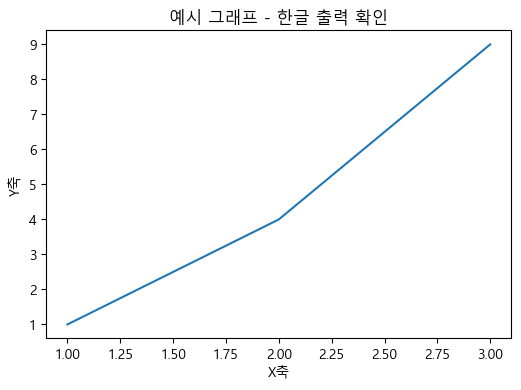

In [2]:
import matplotlib as mpl

# 1. 스타일 설정 (배경 밝게)
plt.style.use('default')

# 2. 한글 폰트 설정 (맑은 고딕)
mpl.rcParams['font.family'] = 'Malgun Gothic'

# 3. 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# ✅ 예시 그래프
plt.figure(figsize=(6, 4))
plt.title("예시 그래프 - 한글 출력 확인")
plt.plot([1, 2, 3], [1, 4, 9])
plt.xlabel("X축")
plt.ylabel("Y축")
plt.show()


타겟값(TOTAL_ELEC) 결측치 개수: 0개
타겟값 결측 비율: 0.00%
중복 행 개수: 754개
중복 행 비율: 2.89%

=== 훈련 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26099 entries, 0 to 26098
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATA_YM       26099 non-null  int64  
 1   AREA_ID       26099 non-null  int64  
 2   AREA_NM       26099 non-null  object 
 3   DIST_CD       26099 non-null  int64  
 4   DIST_NM       26099 non-null  object 
 5   TOTAL_BIDG    26096 non-null  float64
 6   FAC_NEIGH_1   26096 non-null  float64
 7   FAC_NEIGH_2   26096 non-null  float64
 8   FAC_CULT_MTG  26096 non-null  float64
 9   FAC_RELG      26096 non-null  float64
 10  FAC_RETAIL    26096 non-null  float64
 11  FAC_MEDI      26096 non-null  float64
 12  FAC_YOSE      26096 non-null  float64
 13  FAC_TRAIN     26096 non-null  float64
 14  FAC_SPORT     26096 non-null  float64
 15  FAC_STAY      26096 non-null  float64
 16  FAC_LEISURE   260

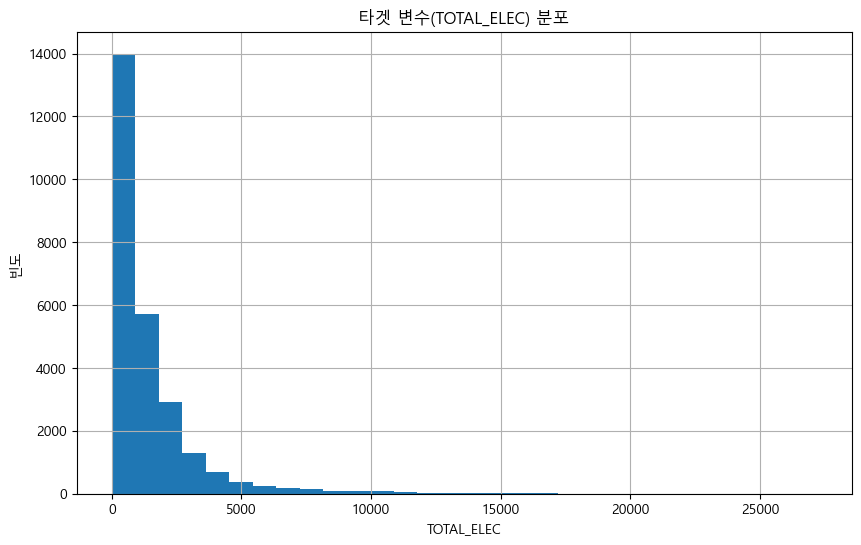

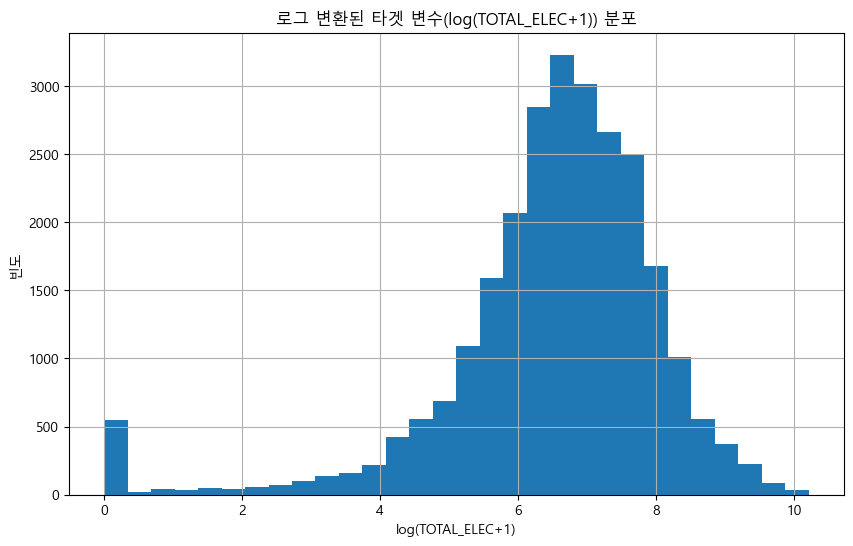

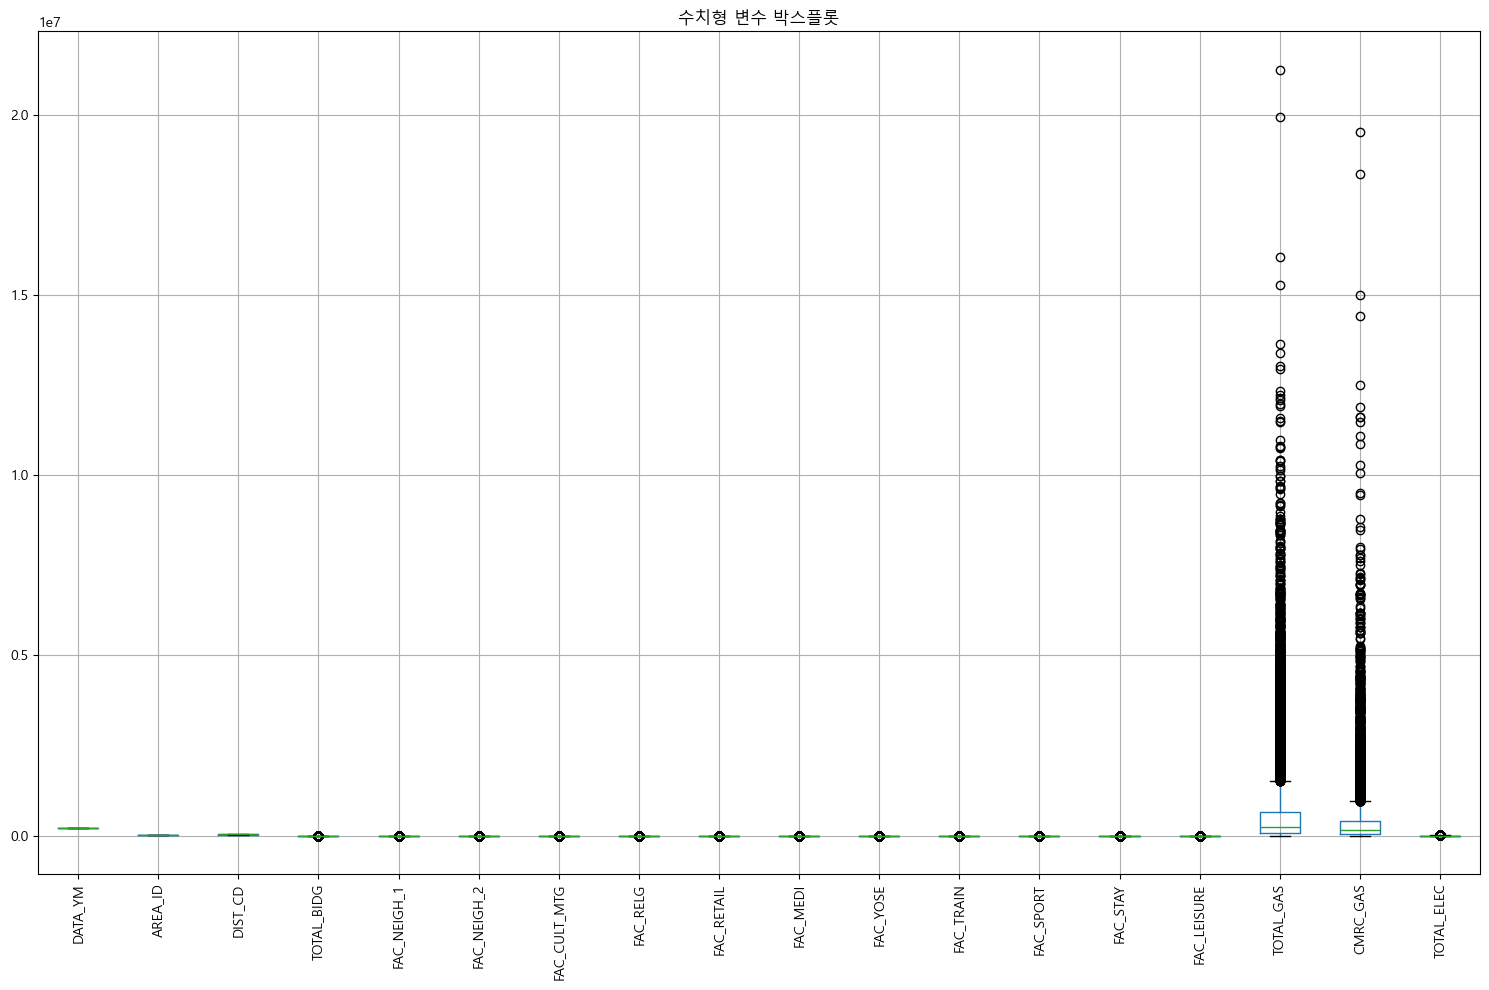

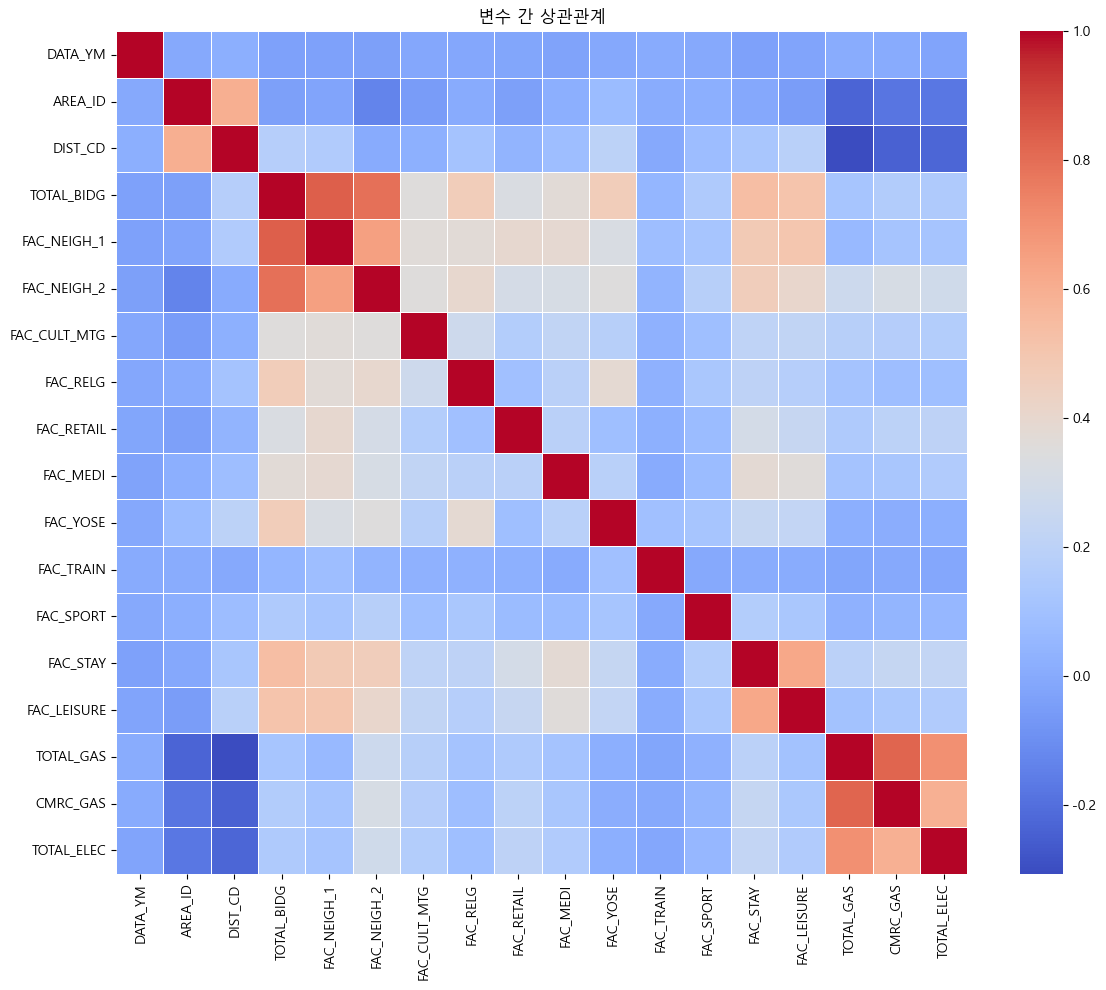


=== 타겟 변수와의 상관관계 ===
TOTAL_ELEC      1.000000
TOTAL_GAS       0.702201
CMRC_GAS        0.596295
FAC_NEIGH_2     0.282637
FAC_STAY        0.226292
FAC_RETAIL      0.206815
FAC_CULT_MTG    0.166282
FAC_MEDI        0.154928
FAC_LEISURE     0.153814
TOTAL_BIDG      0.151817
FAC_NEIGH_1     0.115931
FAC_RELG        0.090287
FAC_SPORT       0.054897
FAC_YOSE        0.018918
FAC_TRAIN      -0.013289
DATA_YM        -0.024666
AREA_ID        -0.176933
DIST_CD        -0.225352
Name: TOTAL_ELEC, dtype: float64


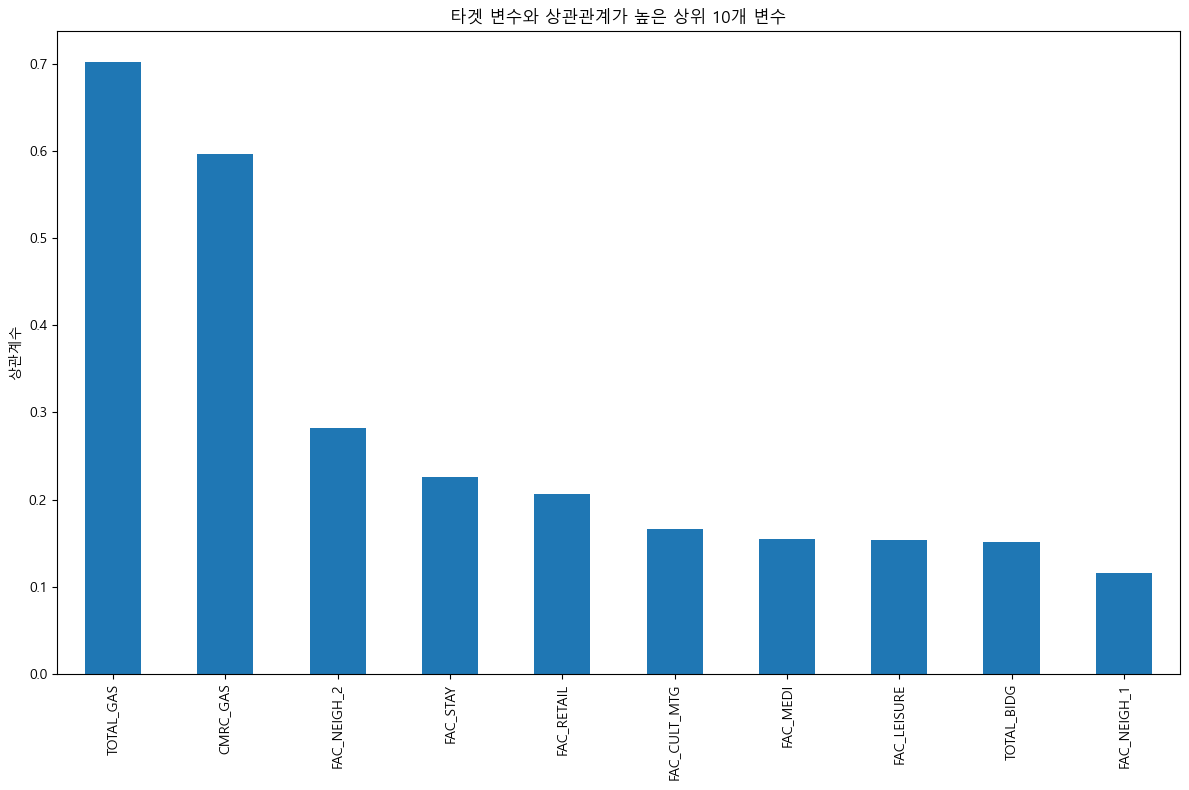

In [3]:
# 타겟값(TOTAL_ELEC) 결측치 확인
target_col = 'TOTAL_ELEC'
missing_target_count = train_df[target_col].isna().sum()
print(f"타겟값(TOTAL_ELEC) 결측치 개수: {missing_target_count}개")
print(f"타겟값 결측 비율: {missing_target_count / len(train_df) * 100:.2f}%")

# 중복 행 확인
duplicate_rows = train_df.duplicated().sum()
print(f"중복 행 개수: {duplicate_rows}개")
print(f"중복 행 비율: {duplicate_rows / len(train_df) * 100:.2f}%")

# 데이터 기본 정보 확인
print("\n=== 훈련 데이터 기본 정보 ===")
print(train_df.info())

# 수치형 변수 통계 요약
print("\n=== 수치형 변수 통계 요약 ===")
print(train_df.describe())

# 각 컬럼별 결측치 확인
print("\n=== 컬럼별 결측치 개수 ===")
missing_values = train_df.isnull().sum()
missing_values_percent = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    '결측치 개수': missing_values,
    '결측치 비율(%)': missing_values_percent.round(2)
})
print(missing_df[missing_df['결측치 개수'] > 0])

# 범주형 변수 확인
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns
print(f"\n=== 범주형 변수 목록 ({len(categorical_cols)}개) ===")
print(categorical_cols.tolist())

# 범주형 변수의 고유값 개수 확인
if len(categorical_cols) > 0:
    print("\n=== 범주형 변수 고유값 개수 ===")
    for col in categorical_cols:
        unique_values = train_df[col].nunique()
        print(f"{col}: {unique_values}개 고유값")

# 타겟 변수 분포 시각화 (결측치 제외)
plt.figure(figsize=(10, 6))
train_df[target_col].dropna().hist(bins=30)
plt.title('타겟 변수(TOTAL_ELEC) 분포')
plt.xlabel('TOTAL_ELEC')
plt.ylabel('빈도')
plt.show()

# 타겟 변수의 로그 변환 분포 시각화 (결측치 제외)
plt.figure(figsize=(10, 6))
np.log1p(train_df[target_col].dropna()).hist(bins=30)
plt.title('로그 변환된 타겟 변수(log(TOTAL_ELEC+1)) 분포')
plt.xlabel('log(TOTAL_ELEC+1)')
plt.ylabel('빈도')
plt.show()

# 이상치 확인 (박스플롯)
plt.figure(figsize=(15, 10))
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
train_df[numerical_cols].boxplot(figsize=(15, 10))
plt.title('수치형 변수 박스플롯')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 상관관계 분석
plt.figure(figsize=(12, 10))
corr_matrix = train_df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('변수 간 상관관계')
plt.tight_layout()
plt.show()

# 타겟 변수와의 상관관계 (결측치 제외)
train_df_no_missing = train_df.dropna(subset=[target_col])
corr_with_target = train_df_no_missing.select_dtypes(include=['int64', 'float64']).corr()[target_col].sort_values(ascending=False)
print("\n=== 타겟 변수와의 상관관계 ===")
print(corr_with_target)

# 타겟 변수와 상관관계가 높은 상위 10개 변수 시각화
plt.figure(figsize=(12, 8))
corr_with_target.drop(target_col).nlargest(10).plot(kind='bar')
plt.title('타겟 변수와 상관관계가 높은 상위 10개 변수')
plt.ylabel('상관계수')
plt.tight_layout()
plt.show()


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26099 entries, 0 to 26098
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATA_YM       26099 non-null  int64  
 1   AREA_ID       26099 non-null  int64  
 2   AREA_NM       26099 non-null  object 
 3   DIST_CD       26099 non-null  int64  
 4   DIST_NM       26099 non-null  object 
 5   TOTAL_BIDG    26096 non-null  float64
 6   FAC_NEIGH_1   26096 non-null  float64
 7   FAC_NEIGH_2   26096 non-null  float64
 8   FAC_CULT_MTG  26096 non-null  float64
 9   FAC_RELG      26096 non-null  float64
 10  FAC_RETAIL    26096 non-null  float64
 11  FAC_MEDI      26096 non-null  float64
 12  FAC_YOSE      26096 non-null  float64
 13  FAC_TRAIN     26096 non-null  float64
 14  FAC_SPORT     26096 non-null  float64
 15  FAC_STAY      26096 non-null  float64
 16  FAC_LEISURE   26096 non-null  float64
 17  TOTAL_GAS     26099 non-null  int64  
 18  CMRC_GAS      26099 non-nu

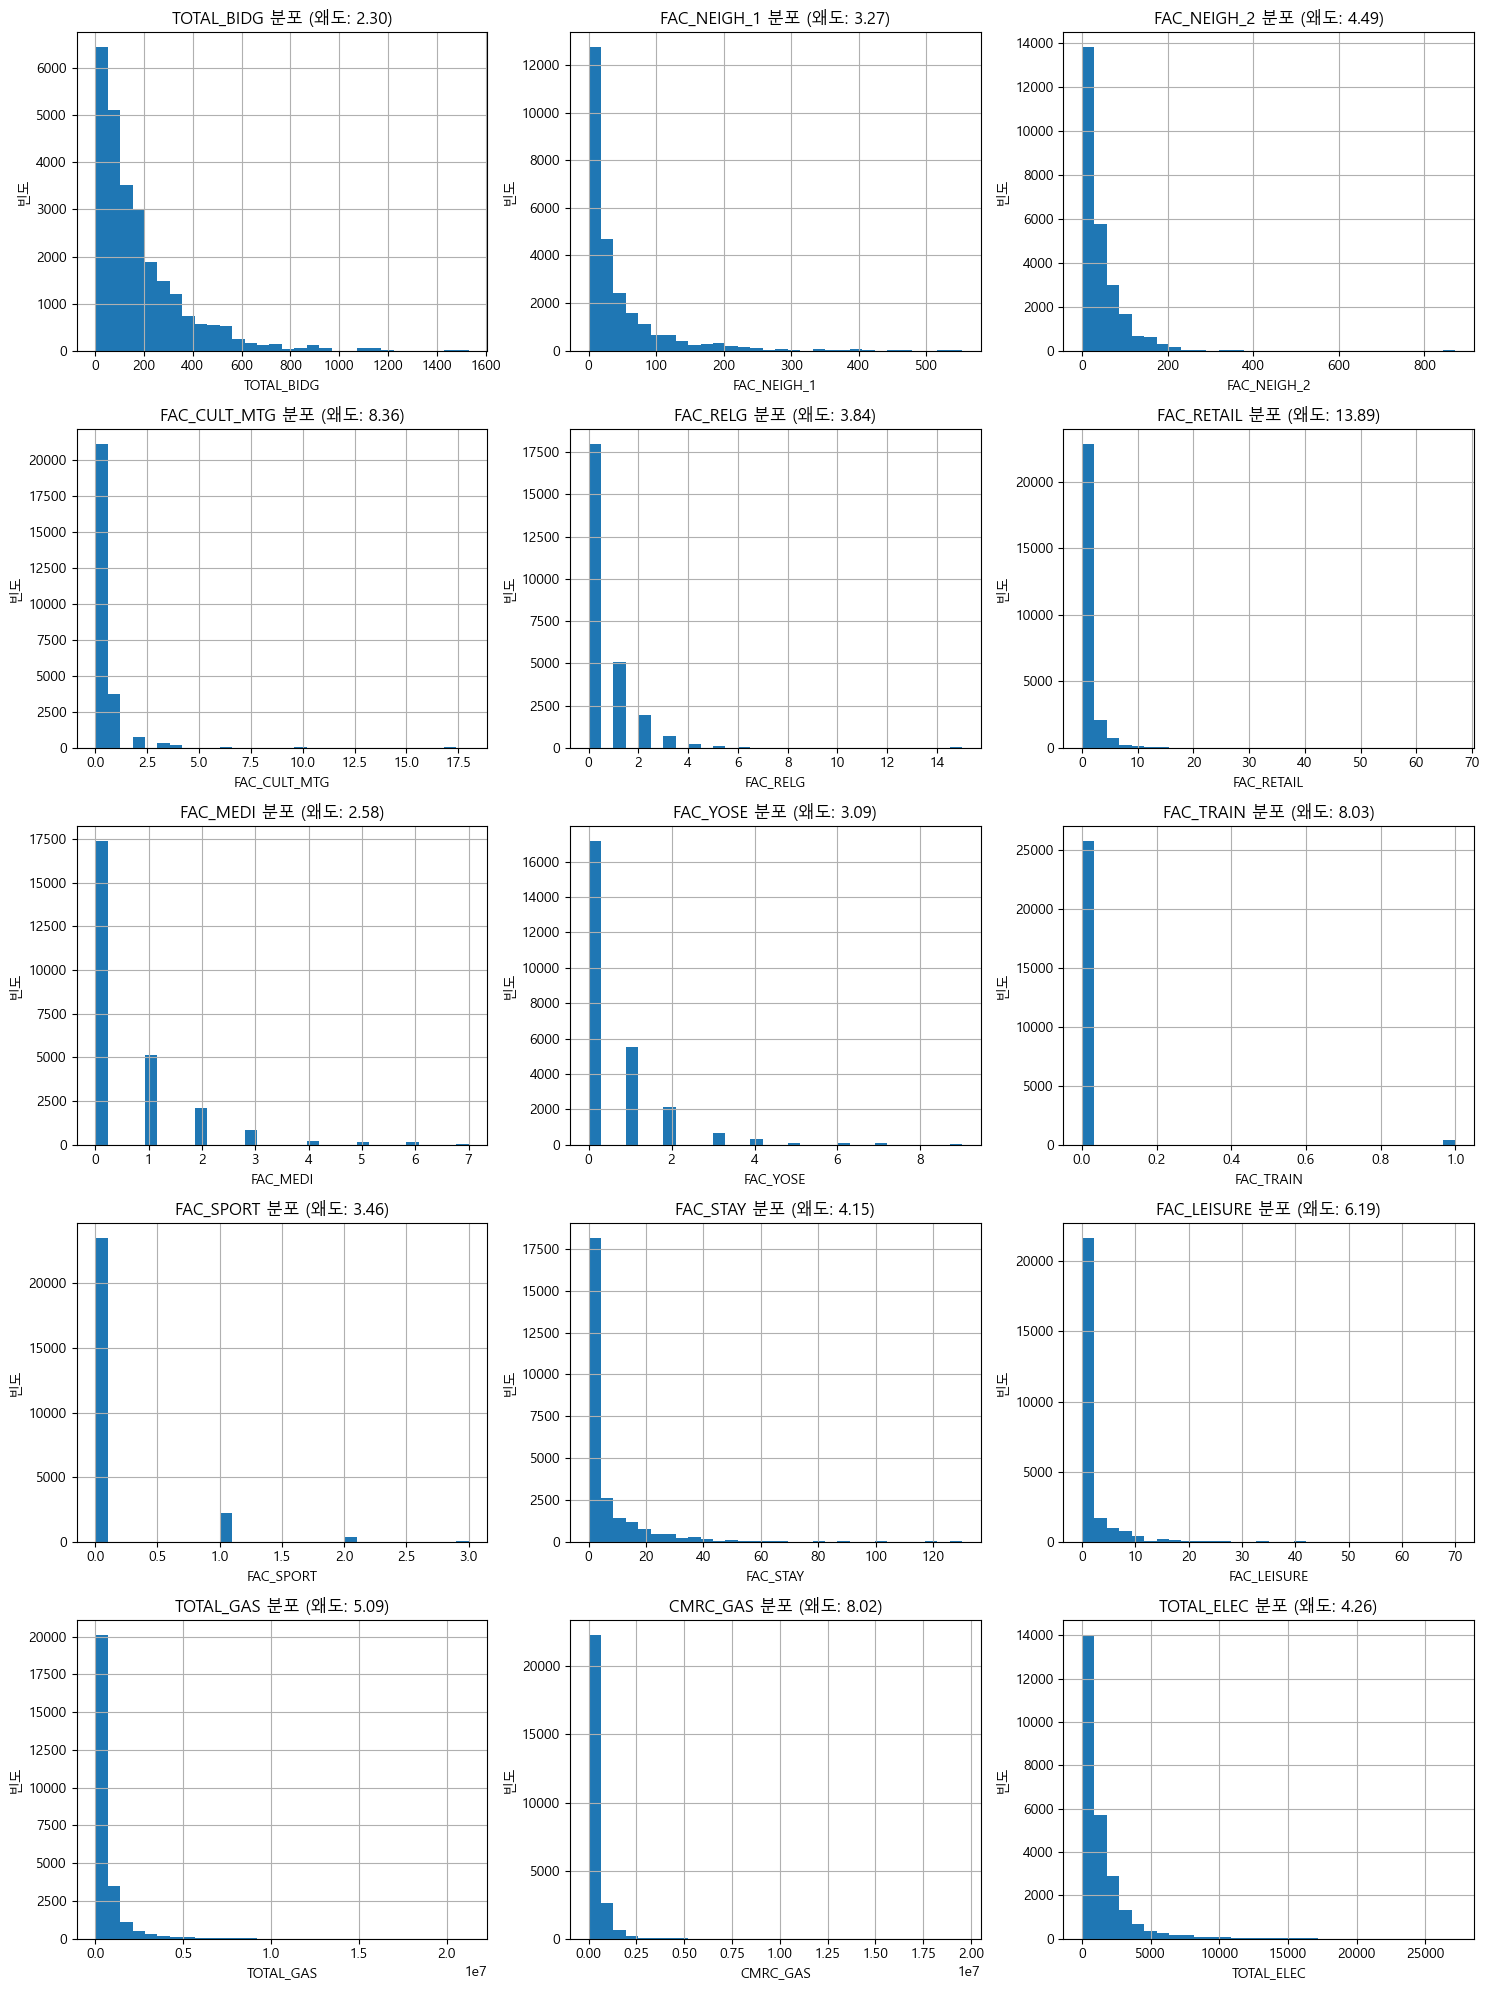

In [5]:
# 수치형 변수 분포 시각화 (DATA_YM, AREA_ID, DIST_CD 제외)
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['DATA_YM', 'AREA_ID', 'DIST_CD']]

# 변수 개수에 따라 서브플롯 행과 열 계산
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    train_df[col].hist(bins=30)
    skewness = train_df[col].skew()
    plt.title(f'{col} 분포 (왜도: {skewness:.2f})')
    plt.xlabel(col)
    plt.ylabel('빈도')
    
plt.tight_layout()
plt.show()


In [28]:
train_df.columns

Index(['DATA_YM', 'AREA_ID', 'AREA_NM', 'DIST_CD', 'DIST_NM', 'TOTAL_BIDG',
       'FAC_NEIGH_1', 'FAC_NEIGH_2', 'FAC_CULT_MTG', 'FAC_RELG', 'FAC_RETAIL',
       'FAC_MEDI', 'FAC_YOSE', 'FAC_TRAIN', 'FAC_SPORT', 'FAC_STAY',
       'FAC_LEISURE', 'TOTAL_GAS', 'CMRC_GAS', 'TOTAL_ELEC', 'IS_DMC',
       'IS_COEX', 'IS_MAPO'],
      dtype='object')

범위가 작은 이산형 변수는 로그변환 x, ,연속형 변수만 로그변환 적용 o, 범위 큰 이산형 변환 o 
- 'TOTAL_BIDG', 'FAC_NEIGH_1', 'FAC_NEIGH_2','FAC_RETAIL','FAC_STAY','FAC_LEISURE', 'TOTAL_GAS', 'CMRC_GAS'
(표준화는 왜 안할까요?)


In [7]:
train_df['FAC_TRAIN'].value_counts()

FAC_TRAIN
0.0    25709
1.0      387
Name: count, dtype: int64


=== FAC_TRAIN 변수에 따른 TOTAL_ELEC 차이 분석 ===

FAC_TRAIN = 0인 그룹의 TOTAL_ELEC 통계:
count    25709.000000
mean      1463.619773
std       2064.871603
min          0.000000
25%        367.358000
50%        820.745000
75%       1773.884000
max      27171.719000
Name: TOTAL_ELEC, dtype: float64

FAC_TRAIN = 1인 그룹의 TOTAL_ELEC 통계:
count     387.000000
mean     1237.810649
std      1085.229810
min         0.000000
25%       525.837000
50%       877.358000
75%      1699.373000
max      6561.681000
Name: TOTAL_ELEC, dtype: float64

두 그룹 간 TOTAL_ELEC 평균 차이: -225.81
FAC_TRAIN = 1인 그룹이 FAC_TRAIN = 0인 그룹보다 평균적으로 -225.81 더 높음


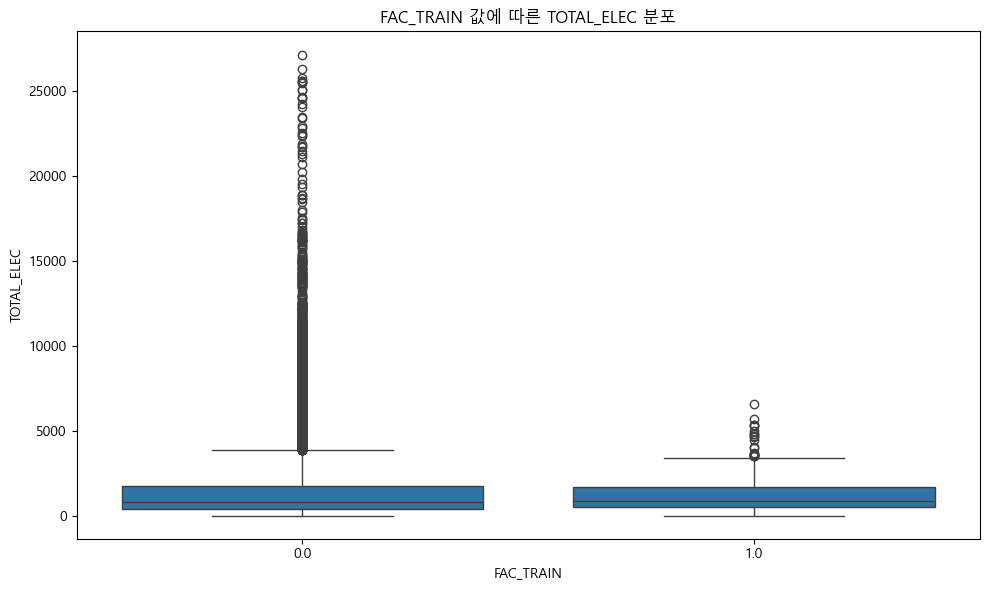

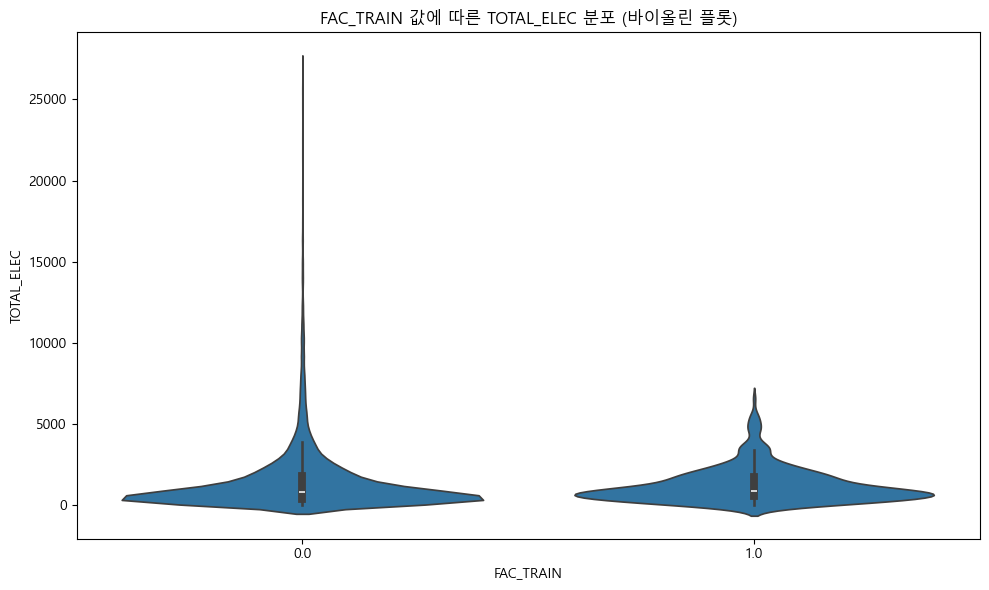


=== 독립표본 t-검정 결과 ===
t-통계량: 3.9861
p-값: 0.0000789131
p-값(0.0000789131)이 유의수준(0.05)보다 작으므로, FAC_TRAIN에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 있습니다.


In [6]:
# FAC_TRAIN 변수에 따른 TOTAL_ELEC 차이 분석
print("\n=== FAC_TRAIN 변수에 따른 TOTAL_ELEC 차이 분석 ===")

# FAC_TRAIN 값에 따른 그룹 생성
group_0 = train_df[train_df['FAC_TRAIN'] == 0]['TOTAL_ELEC']
group_1 = train_df[train_df['FAC_TRAIN'] == 1]['TOTAL_ELEC']

# 각 그룹의 기술 통계량 출력
print("\nFAC_TRAIN = 0인 그룹의 TOTAL_ELEC 통계:")
print(group_0.describe())

print("\nFAC_TRAIN = 1인 그룹의 TOTAL_ELEC 통계:")
print(group_1.describe())

# 평균 차이 계산
mean_diff = group_1.mean() - group_0.mean()
print(f"\n두 그룹 간 TOTAL_ELEC 평균 차이: {mean_diff:.2f}")
print(f"FAC_TRAIN = 1인 그룹이 FAC_TRAIN = 0인 그룹보다 평균적으로 {mean_diff:.2f} 더 높음")

# 시각화 - 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='FAC_TRAIN', y='TOTAL_ELEC', data=train_df)
plt.title('FAC_TRAIN 값에 따른 TOTAL_ELEC 분포')
plt.xlabel('FAC_TRAIN')
plt.ylabel('TOTAL_ELEC')
plt.tight_layout()
plt.show()

# 시각화 - 바이올린 플롯
plt.figure(figsize=(10, 6))
sns.violinplot(x='FAC_TRAIN', y='TOTAL_ELEC', data=train_df)
plt.title('FAC_TRAIN 값에 따른 TOTAL_ELEC 분포 (바이올린 플롯)')
plt.xlabel('FAC_TRAIN')
plt.ylabel('TOTAL_ELEC')
plt.tight_layout()
plt.show()

# 통계적 검정 - t-test
from scipy import stats
t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)  # 등분산 가정하지 않음

print("\n=== 독립표본 t-검정 결과 ===")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-값: {p_value:.10f}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print(f"p-값({p_value:.10f})이 유의수준({alpha})보다 작으므로, FAC_TRAIN에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 있습니다.")
else:
    print(f"p-값({p_value:.10f})이 유의수준({alpha})보다 크므로, FAC_TRAIN에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 없습니다.")



=== AREA_NM이 '디지털미디어시티'인지 여부에 따른 TOTAL_ELEC 차이 분석 ===
IS_DMC 값 분포:
IS_DMC
0    26075
1       24
Name: count, dtype: int64

IS_DMC = 0인 그룹(디지털미디어시티 외 지역)의 TOTAL_ELEC 통계:
count    26075.00000
mean      1441.37346
std       1950.49893
min          0.00000
25%        368.41950
50%        820.75200
75%       1769.33800
max      23475.56300
Name: TOTAL_ELEC, dtype: float64

IS_DMC = 1인 그룹(디지털미디어시티)의 TOTAL_ELEC 통계:
count       24.000000
mean     21809.339625
std       6416.769474
min       5211.186000
25%      21657.095250
50%      24432.814000
75%      25517.789750
max      27171.719000
Name: TOTAL_ELEC, dtype: float64

두 그룹 간 TOTAL_ELEC 평균 차이: 20367.97
디지털미디어시티가 다른 지역보다 평균적으로 20367.97 더 높음


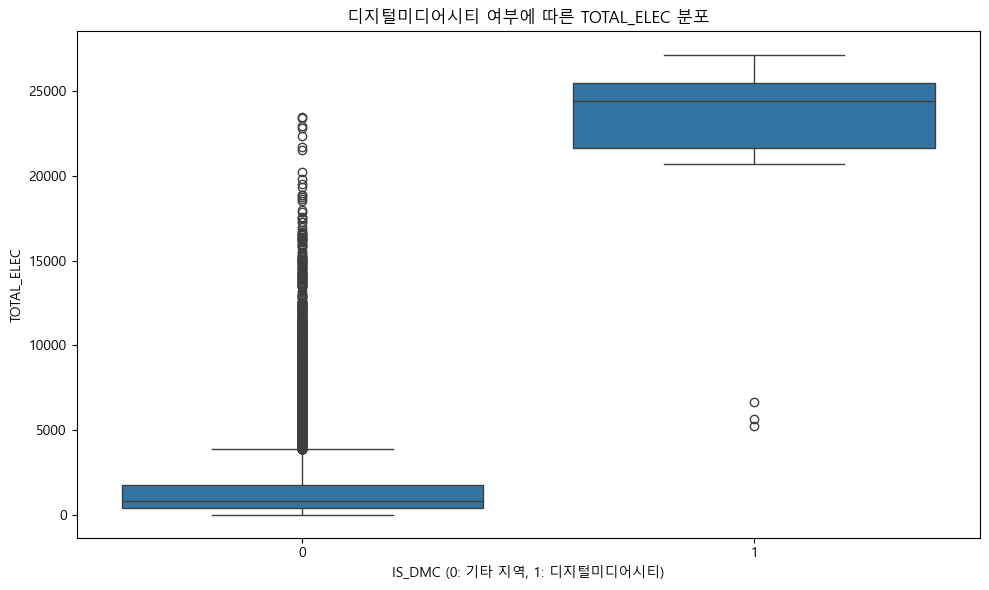

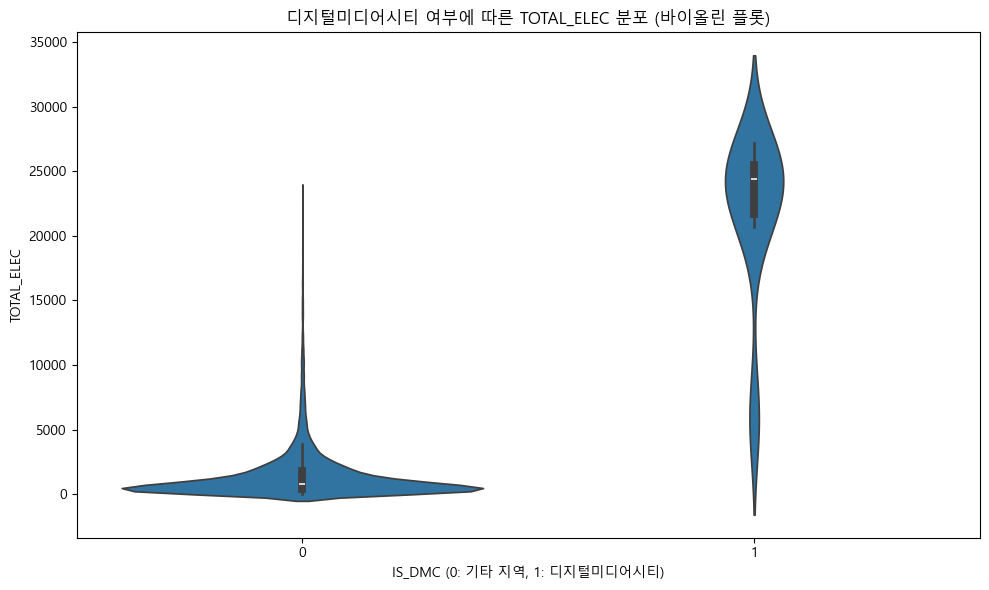


=== 독립표본 t-검정 결과 ===
t-통계량: -15.5496
p-값: 0.0000000000
p-값(0.0000000000)이 유의수준(0.05)보다 작으므로, 디지털미디어시티 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 있습니다.


In [8]:
# AREA_NM이 '디지털미디어시티'인지 여부에 따른 TOTAL_ELEC 차이 분석
print("\n=== AREA_NM이 '디지털미디어시티'인지 여부에 따른 TOTAL_ELEC 차이 분석 ===")

# 새로운 변수 생성: 디지털미디어시티 여부 (1: 디지털미디어시티, 0: 그 외)
train_df['IS_DMC'] = (train_df['AREA_NM'] == '디지털미디어시티').astype(int)

# IS_DMC 값 분포 확인
print("IS_DMC 값 분포:")
print(train_df['IS_DMC'].value_counts())

# IS_DMC 값에 따른 그룹 생성
group_0 = train_df[train_df['IS_DMC'] == 0]['TOTAL_ELEC']
group_1 = train_df[train_df['IS_DMC'] == 1]['TOTAL_ELEC']

# 각 그룹의 기술 통계량 출력
print("\nIS_DMC = 0인 그룹(디지털미디어시티 외 지역)의 TOTAL_ELEC 통계:")
print(group_0.describe())

print("\nIS_DMC = 1인 그룹(디지털미디어시티)의 TOTAL_ELEC 통계:")
print(group_1.describe())

# 평균 차이 계산
mean_diff = group_1.mean() - group_0.mean()
print(f"\n두 그룹 간 TOTAL_ELEC 평균 차이: {mean_diff:.2f}")
if mean_diff > 0:
    print(f"디지털미디어시티가 다른 지역보다 평균적으로 {mean_diff:.2f} 더 높음")
else:
    print(f"디지털미디어시티가 다른 지역보다 평균적으로 {abs(mean_diff):.2f} 더 낮음")

# 시각화 - 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='IS_DMC', y='TOTAL_ELEC', data=train_df)
plt.title('디지털미디어시티 여부에 따른 TOTAL_ELEC 분포')
plt.xlabel('IS_DMC (0: 기타 지역, 1: 디지털미디어시티)')
plt.ylabel('TOTAL_ELEC')
plt.tight_layout()
plt.show()

# 시각화 - 바이올린 플롯
plt.figure(figsize=(10, 6))
sns.violinplot(x='IS_DMC', y='TOTAL_ELEC', data=train_df)
plt.title('디지털미디어시티 여부에 따른 TOTAL_ELEC 분포 (바이올린 플롯)')
plt.xlabel('IS_DMC (0: 기타 지역, 1: 디지털미디어시티)')
plt.ylabel('TOTAL_ELEC')
plt.tight_layout()
plt.show()

# 통계적 검정 - t-test
from scipy import stats
t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)  # 등분산 가정하지 않음

print("\n=== 독립표본 t-검정 결과 ===")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-값: {p_value:.10f}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print(f"p-값({p_value:.10f})이 유의수준({alpha})보다 작으므로, 디지털미디어시티 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 있습니다.")
else:
    print(f"p-값({p_value:.10f})이 유의수준({alpha})보다 크므로, 디지털미디어시티 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 없습니다.")



=== AREA_NM이 '코엑스'인지 여부에 따른 TOTAL_ELEC 차이 분석 ===
IS_COEX 값 분포:
IS_COEX
0    26079
1       20
Name: count, dtype: int64

IS_COEX = 0인 그룹(코엑스 외 지역)의 TOTAL_ELEC 통계:
count    26079.000000
mean      1448.567224
std       2008.729961
min          0.000000
25%        368.484500
50%        821.190000
75%       1770.342500
max      27171.719000
Name: TOTAL_ELEC, dtype: float64

IS_COEX = 1인 그룹(코엑스)의 TOTAL_ELEC 통계:
count       20.000000
mean     16502.624700
std       4216.789324
min       8621.543000
25%      14847.645750
50%      15537.191000
75%      18881.448500
max      23475.563000
Name: TOTAL_ELEC, dtype: float64

두 그룹 간 TOTAL_ELEC 평균 차이: 15054.06
코엑스가 다른 지역보다 평균적으로 15054.06 더 높음


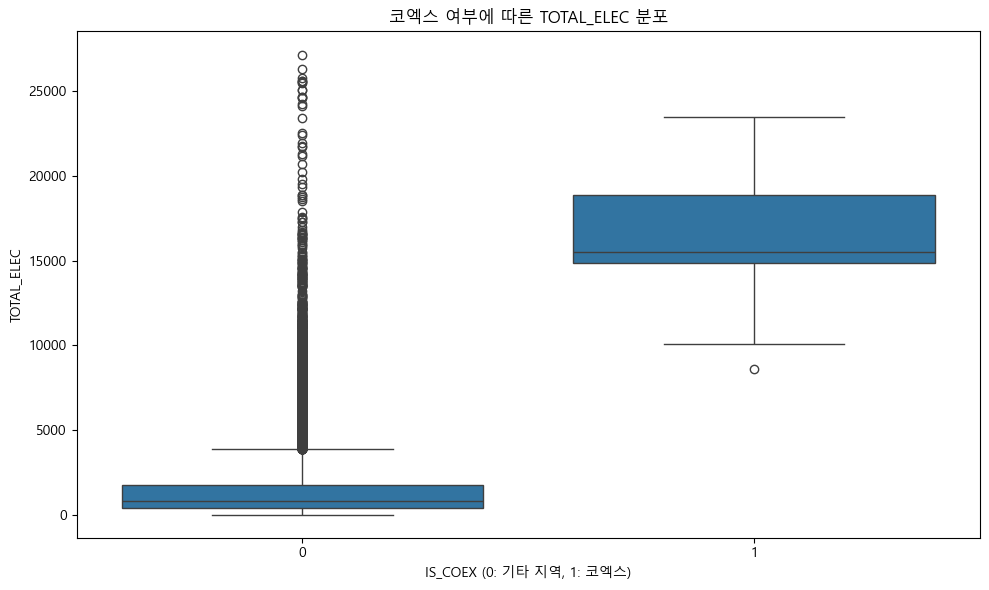

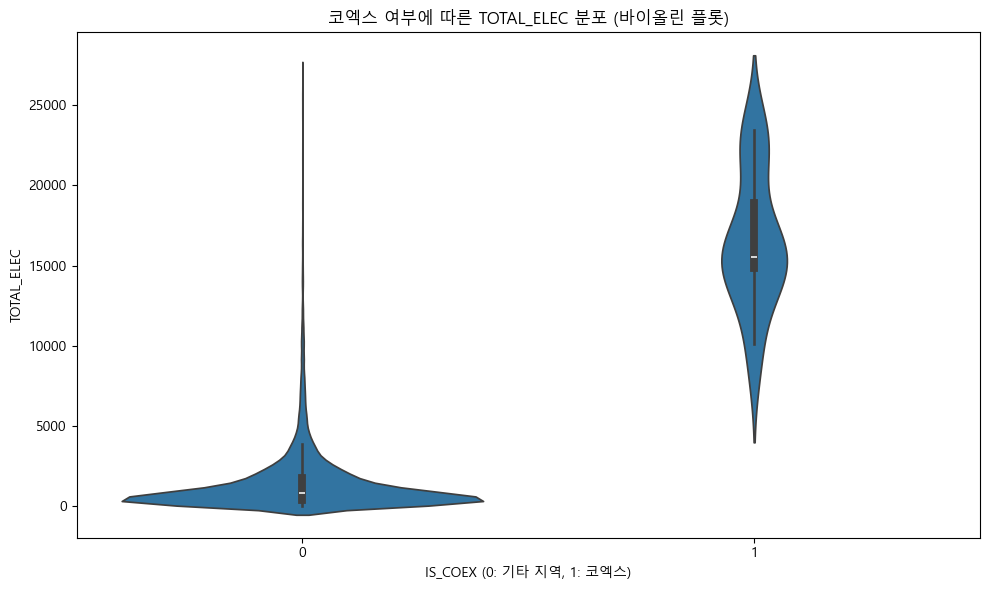


=== 독립표본 t-검정 결과 ===
t-통계량: -15.9643
p-값: 0.0000000000
p-값(0.0000000000)이 유의수준(0.05)보다 작으므로, 코엑스 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 있습니다.


In [9]:
# AREA_NM이 '코엑스'인지 여부에 따른 TOTAL_ELEC 차이 분석
print("\n=== AREA_NM이 '코엑스'인지 여부에 따른 TOTAL_ELEC 차이 분석 ===")

# 새로운 변수 생성: 코엑스 여부 (1: 코엑스, 0: 그 외)
train_df['IS_COEX'] = (train_df['AREA_NM'] == '코엑스').astype(int)

# IS_COEX 값 분포 확인
print("IS_COEX 값 분포:")
print(train_df['IS_COEX'].value_counts())

# IS_COEX 값에 따른 그룹 생성
group_0 = train_df[train_df['IS_COEX'] == 0]['TOTAL_ELEC']
group_1 = train_df[train_df['IS_COEX'] == 1]['TOTAL_ELEC']

# 각 그룹의 기술 통계량 출력
print("\nIS_COEX = 0인 그룹(코엑스 외 지역)의 TOTAL_ELEC 통계:")
print(group_0.describe())

print("\nIS_COEX = 1인 그룹(코엑스)의 TOTAL_ELEC 통계:")
print(group_1.describe())

# 평균 차이 계산
mean_diff = group_1.mean() - group_0.mean()
print(f"\n두 그룹 간 TOTAL_ELEC 평균 차이: {mean_diff:.2f}")
if mean_diff > 0:
    print(f"코엑스가 다른 지역보다 평균적으로 {mean_diff:.2f} 더 높음")
else:
    print(f"코엑스가 다른 지역보다 평균적으로 {abs(mean_diff):.2f} 더 낮음")

# 시각화 - 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='IS_COEX', y='TOTAL_ELEC', data=train_df)
plt.title('코엑스 여부에 따른 TOTAL_ELEC 분포')
plt.xlabel('IS_COEX (0: 기타 지역, 1: 코엑스)')
plt.ylabel('TOTAL_ELEC')
plt.tight_layout()
plt.show()

# 시각화 - 바이올린 플롯
plt.figure(figsize=(10, 6))
sns.violinplot(x='IS_COEX', y='TOTAL_ELEC', data=train_df)
plt.title('코엑스 여부에 따른 TOTAL_ELEC 분포 (바이올린 플롯)')
plt.xlabel('IS_COEX (0: 기타 지역, 1: 코엑스)')
plt.ylabel('TOTAL_ELEC')
plt.tight_layout()
plt.show()

# 통계적 검정 - t-test
from scipy import stats
t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)  # 등분산 가정하지 않음

print("\n=== 독립표본 t-검정 결과 ===")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-값: {p_value:.10f}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print(f"p-값({p_value:.10f})이 유의수준({alpha})보다 작으므로, 코엑스 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 있습니다.")
else:
    print(f"p-값({p_value:.10f})이 유의수준({alpha})보다 크므로, 코엑스 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 없습니다.")



=== DIST_NM이 '마포구'인지 여부에 따른 TOTAL_ELEC 차이 분석 ===
IS_MAPO 값 분포:
IS_MAPO
0    25867
1      232
Name: count, dtype: int64

IS_MAPO = 0인 그룹(마포구 외 지역)의 TOTAL_ELEC 통계:
count    25867.000000
mean      1433.763747
std       1932.765222
min          0.000000
25%        366.112000
50%        817.381000
75%       1765.949500
max      23475.563000
Name: TOTAL_ELEC, dtype: float64

IS_MAPO = 1인 그룹(마포구)의 TOTAL_ELEC 통계:
count      232.000000
mean      4396.854664
std       7039.809933
min          5.739000
25%        710.802750
50%       1346.391500
75%       2991.646000
max      27171.719000
Name: TOTAL_ELEC, dtype: float64

두 그룹 간 TOTAL_ELEC 평균 차이: 2963.09
마포구가 다른 지역보다 평균적으로 2963.09 더 높음


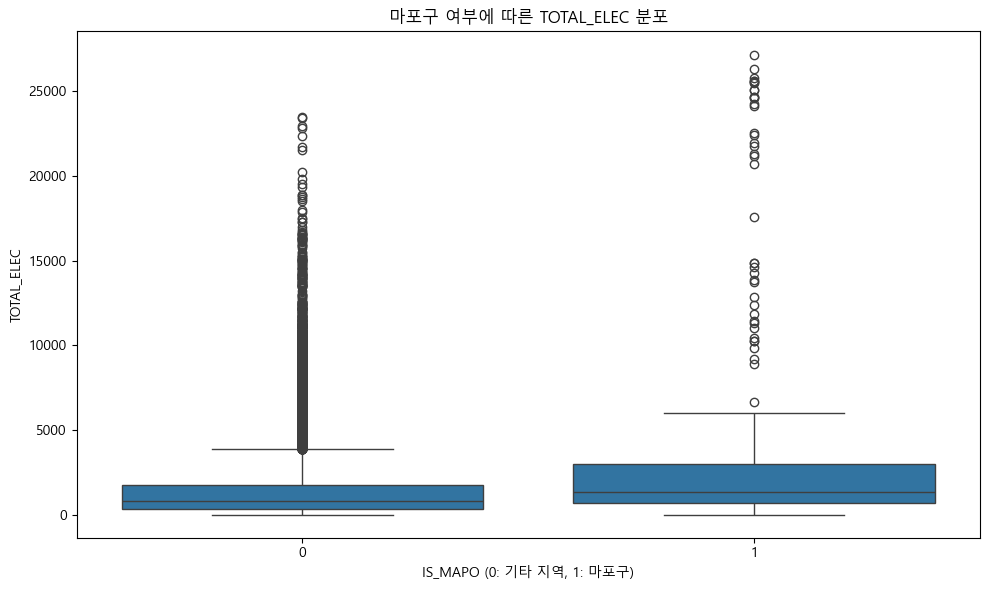

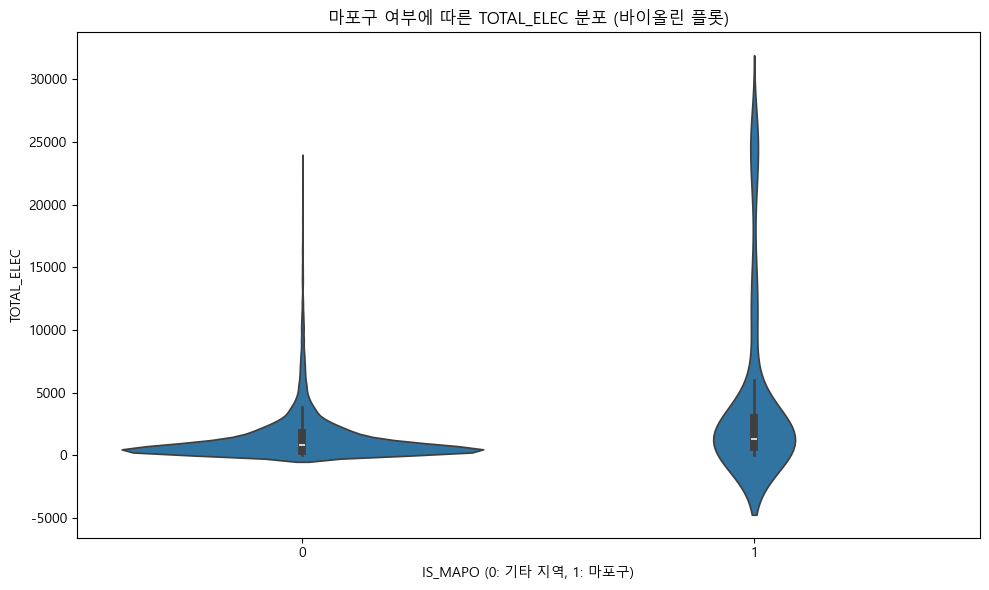


=== 독립표본 t-검정 결과 ===
t-통계량: -6.4089
p-값: 0.0000000008
p-값(0.0000000008)이 유의수준(0.05)보다 작으므로, 마포구 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 있습니다.


In [10]:
# DIST_NM이 '마포구'인지 여부에 따른 TOTAL_ELEC 차이 분석
print("\n=== DIST_NM이 '마포구'인지 여부에 따른 TOTAL_ELEC 차이 분석 ===")

# 새로운 변수 생성: 마포구 여부 (1: 마포구, 0: 그 외)
train_df['IS_MAPO'] = (train_df['DIST_NM'] == '마포구').astype(int)

# IS_MAPO 값 분포 확인
print("IS_MAPO 값 분포:")
print(train_df['IS_MAPO'].value_counts())

# IS_MAPO 값에 따른 그룹 생성
group_0 = train_df[train_df['IS_MAPO'] == 0]['TOTAL_ELEC']
group_1 = train_df[train_df['IS_MAPO'] == 1]['TOTAL_ELEC']

# 각 그룹의 기술 통계량 출력
print("\nIS_MAPO = 0인 그룹(마포구 외 지역)의 TOTAL_ELEC 통계:")
print(group_0.describe())

print("\nIS_MAPO = 1인 그룹(마포구)의 TOTAL_ELEC 통계:")
print(group_1.describe())

# 평균 차이 계산
mean_diff = group_1.mean() - group_0.mean()
print(f"\n두 그룹 간 TOTAL_ELEC 평균 차이: {mean_diff:.2f}")
if mean_diff > 0:
    print(f"마포구가 다른 지역보다 평균적으로 {mean_diff:.2f} 더 높음")
else:
    print(f"마포구가 다른 지역보다 평균적으로 {abs(mean_diff):.2f} 더 낮음")

# 시각화 - 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='IS_MAPO', y='TOTAL_ELEC', data=train_df)
plt.title('마포구 여부에 따른 TOTAL_ELEC 분포')
plt.xlabel('IS_MAPO (0: 기타 지역, 1: 마포구)')
plt.ylabel('TOTAL_ELEC')
plt.tight_layout()
plt.show()

# 시각화 - 바이올린 플롯
plt.figure(figsize=(10, 6))
sns.violinplot(x='IS_MAPO', y='TOTAL_ELEC', data=train_df)
plt.title('마포구 여부에 따른 TOTAL_ELEC 분포 (바이올린 플롯)')
plt.xlabel('IS_MAPO (0: 기타 지역, 1: 마포구)')
plt.ylabel('TOTAL_ELEC')
plt.tight_layout()
plt.show()

# 통계적 검정 - t-test
from scipy import stats
t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)  # 등분산 가정하지 않음

print("\n=== 독립표본 t-검정 결과 ===")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-값: {p_value:.10f}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print(f"p-값({p_value:.10f})이 유의수준({alpha})보다 작으므로, 마포구 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 있습니다.")
else:
    print(f"p-값({p_value:.10f})이 유의수준({alpha})보다 크므로, 마포구 여부에 따른 TOTAL_ELEC 평균에 통계적으로 유의한 차이가 없습니다.")



=== DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정 ===
원핫 인코딩된 변수 수: 1367

=== 통계적으로 유의한 변수 (1219개) ===
         variable  p_value    mean_diff      t_stat
0        DIST_거창군      0.0 -1374.120934  -95.291895
1        DIST_산청군      0.0 -1428.787139 -110.512188
2        DIST_옥천군      0.0 -1430.737991 -108.935126
3        AREA_가능역      0.0 -1426.674486 -110.284752
4      AREA_가평터미널      0.0 -1375.444878 -101.825196
5    AREA_간성시장 상권      0.0 -1427.540468 -106.800118
6      AREA_거창읍_2      0.0 -1408.113996 -105.476074
7        AREA_교육청      0.0 -1403.839857 -104.918592
8        AREA_기흥역      0.0 -1357.663507  -98.119266
9     AREA_남원주중학교      0.0 -1441.109754 -111.589093
10   AREA_덕소초등학교앞      0.0 -1408.936199 -102.856538
11     AREA_동아대병원      0.0 -1369.766323 -100.368053
12  AREA_미아사거리역_2      0.0 -1356.234753 -101.614908
13       AREA_사하역      0.0 -1391.883201 -107.679954
14       AREA_산청읍      0.0 -1428.787139 -110.512188
15       AREA_스무숲      0.0 -1402.287977 -100.312060
16      AREA_시흥4동      0

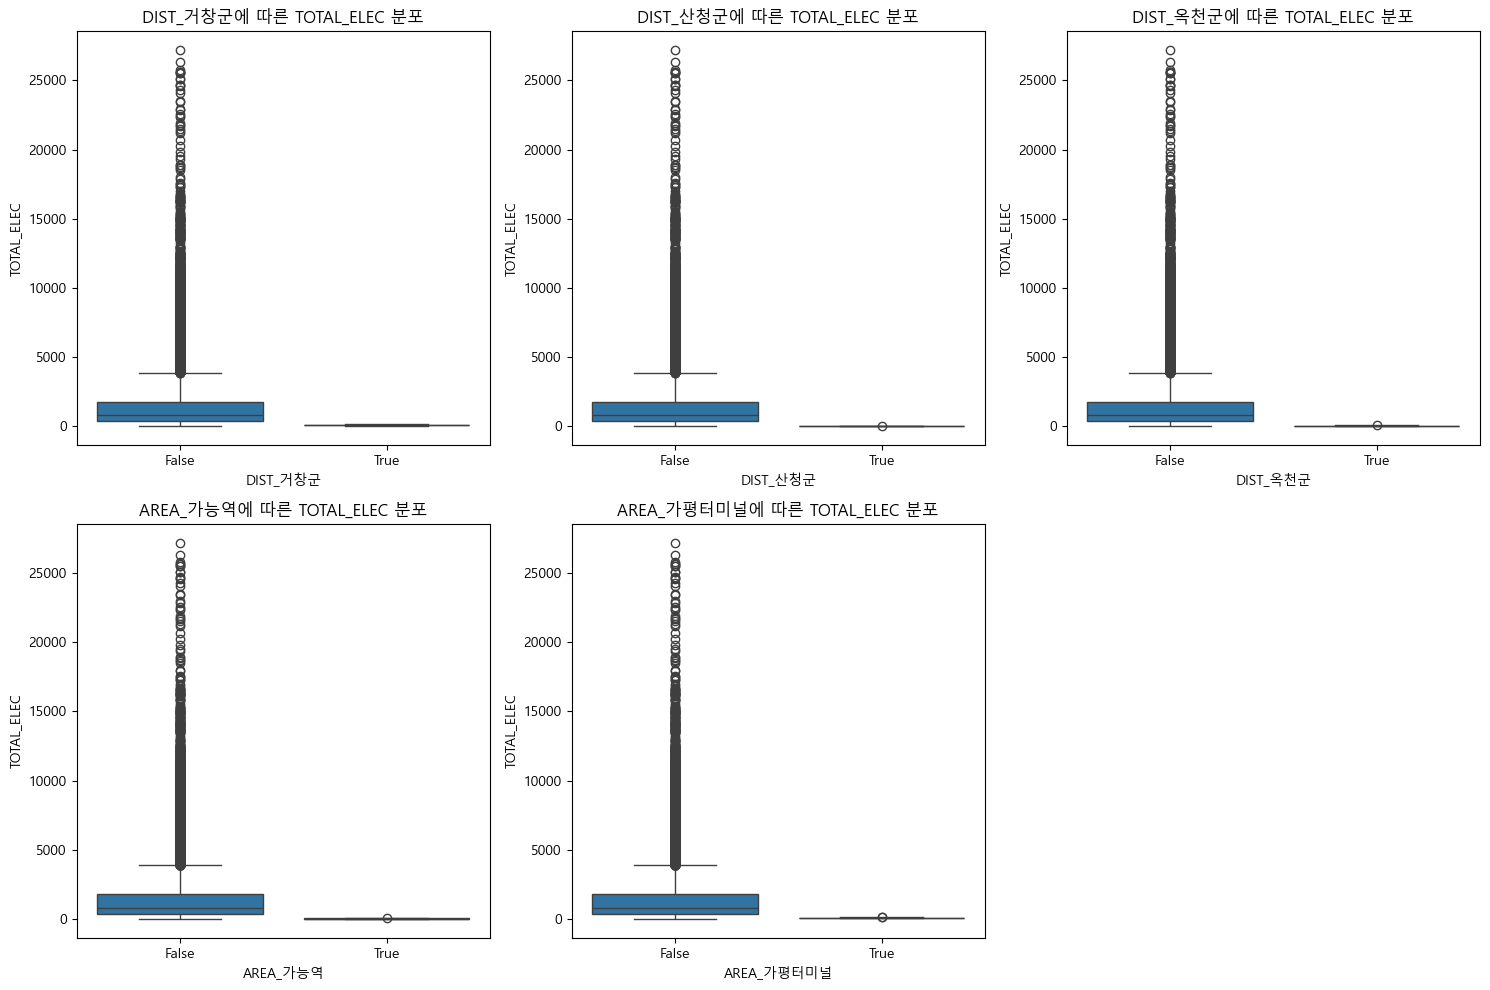

In [11]:
# DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정
print("\n=== DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정 ===")

# 원핫 인코딩 수행
dist_dummies = pd.get_dummies(train_df['DIST_NM'], prefix='DIST')
area_dummies = pd.get_dummies(train_df['AREA_NM'], prefix='AREA')

# 원핫 인코딩된 데이터프레임 생성
encoded_df = pd.concat([train_df, dist_dummies, area_dummies], axis=1)

# 원핫 인코딩된 변수 목록 확인
encoded_columns = list(dist_dummies.columns) + list(area_dummies.columns)
print(f"원핫 인코딩된 변수 수: {len(encoded_columns)}")

# 통계적 검정 결과를 저장할 리스트
significant_vars = []
non_significant_vars = []

# 각 원핫 인코딩 변수에 대해 통계적 검정 수행
for col in encoded_columns:
    # 해당 변수가 1인 그룹과 0인 그룹으로 나누기
    group_1 = train_df.loc[encoded_df[col] == 1, 'TOTAL_ELEC']
    group_0 = train_df.loc[encoded_df[col] == 0, 'TOTAL_ELEC']
    
    # 그룹 크기가 너무 작으면 건너뛰기
    if len(group_1) < 10 or len(group_0) < 10:
        print(f"{col}: 그룹 크기가 너무 작아 검정을 수행하지 않습니다.")
        continue
    
    # t-test 수행
    t_stat, p_value = stats.ttest_ind(group_1, group_0, equal_var=False)
    
    # 평균 차이 계산
    mean_diff = group_1.mean() - group_0.mean()
    
    # 유의성 판단 및 결과 저장
    alpha = 0.05
    result_dict = {
        'variable': col,
        'p_value': p_value,
        'mean_diff': mean_diff,
        't_stat': t_stat
    }
    
    if p_value < alpha:
        significant_vars.append(result_dict)
    else:
        non_significant_vars.append(result_dict)

# 결과 정렬 (p-value 기준)
significant_vars = sorted(significant_vars, key=lambda x: x['p_value'])
non_significant_vars = sorted(non_significant_vars, key=lambda x: x['p_value'])

# 유의한 변수 출력
print(f"\n=== 통계적으로 유의한 변수 ({len(significant_vars)}개) ===")
if significant_vars:
    significant_df = pd.DataFrame(significant_vars)
    print(significant_df[['variable', 'p_value', 'mean_diff', 't_stat']].head(20))
    print(f"... 외 {max(0, len(significant_vars) - 20)}개")
else:
    print("통계적으로 유의한 변수가 없습니다.")

# 유의하지 않은 변수 출력
print(f"\n=== 통계적으로 유의하지 않은 변수 ({len(non_significant_vars)}개) ===")
if non_significant_vars:
    non_significant_df = pd.DataFrame(non_significant_vars)
    print(non_significant_df[['variable', 'p_value', 'mean_diff', 't_stat']].head(20))
    print(f"... 외 {max(0, len(non_significant_vars) - 20)}개")
else:
    print("통계적으로 유의하지 않은 변수가 없습니다.")

# 유의한 변수들의 분포 시각화 (상위 5개만)
if significant_vars:
    top_vars = [var['variable'] for var in significant_vars[:5]]
    
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(top_vars):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x=encoded_df[var], y=train_df['TOTAL_ELEC'], data=train_df)
        plt.title(f'{var}에 따른 TOTAL_ELEC 분포')
        plt.xlabel(var)
        plt.ylabel('TOTAL_ELEC')
    
    plt.tight_layout()
    plt.show()



=== DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정 ===
원핫 인코딩된 변수 수: 1367

=== 표본 크기가 30보다 작은 변수 (1196개) ===
                variable  group_1_size  group_0_size
0              AREA_LC타워            22         26077
1               AREA_MBC            23         26076
2               AREA_가능역            24         26075
3         AREA_가능역2-3번출구            27         26072
4              AREA_가락시장            25         26074
5             AREA_가락시장역            23         26076
6   AREA_가리봉시장(구로디지털오거리)            22         26077
7        AREA_가산디지털단지역_1            25         26074
8        AREA_가산디지털단지역_2            25         26074
9        AREA_가산디지털단지역_3            24         26075
10          AREA_가야대학교 앞            22         26077
11              AREA_가오동            22         26077
12             AREA_가정1동            21         26078
13          AREA_가천의대길병원            22         26077
14              AREA_가평읍            21         26078
15            AREA_가평터미널            26         26073
16

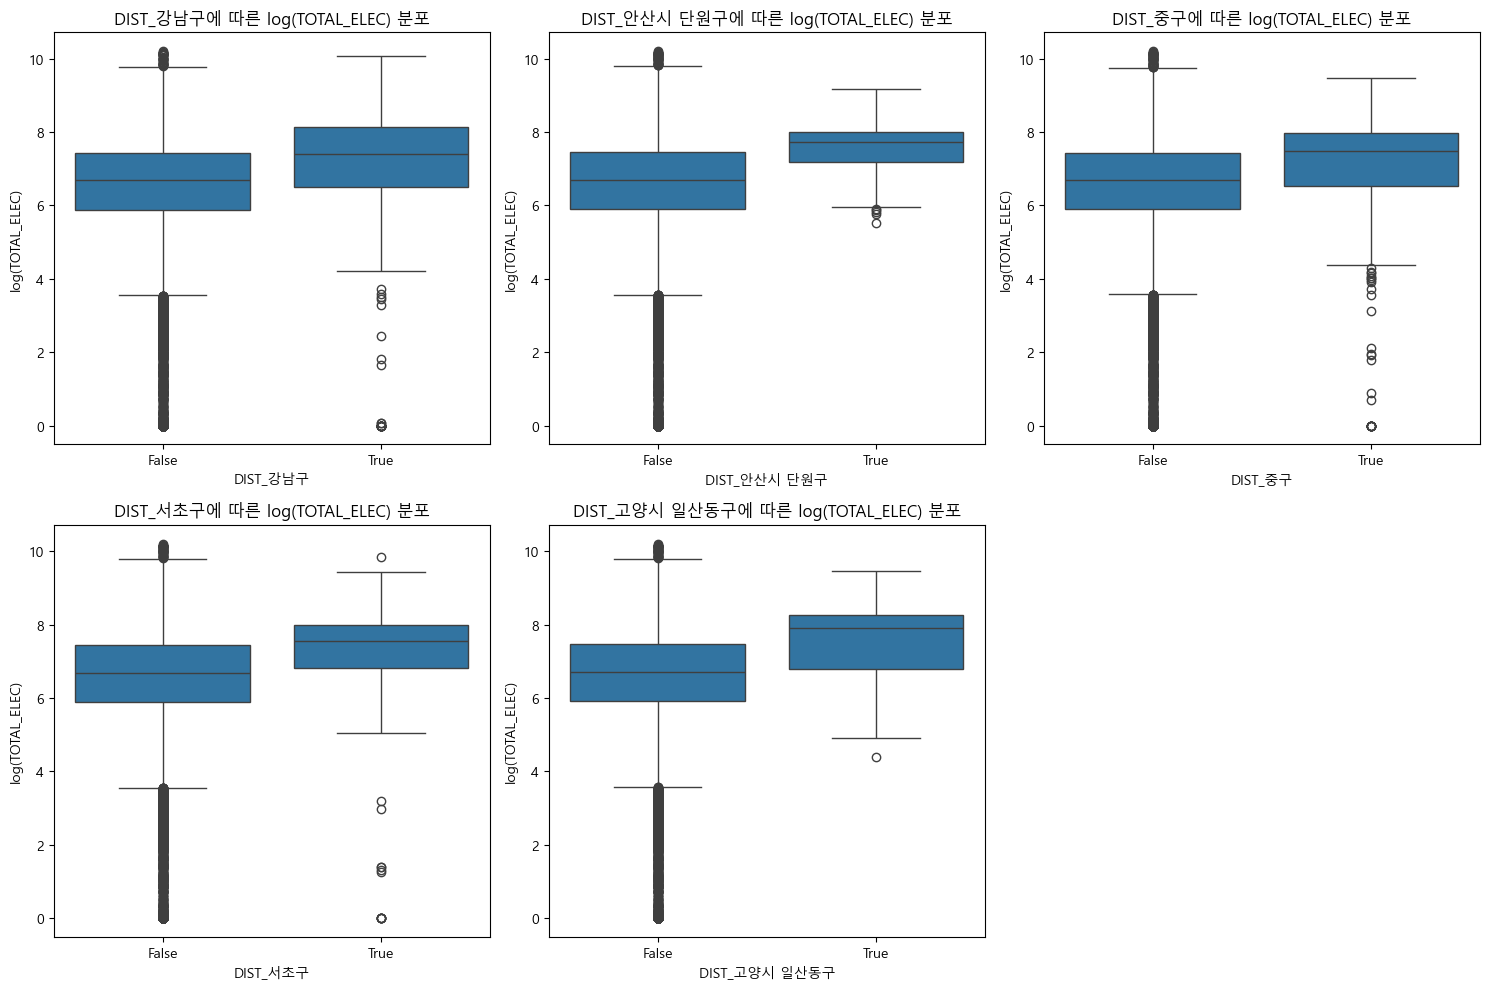

In [ ]:
# DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정
print("\n=== DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정 ===")

# 원핫 인코딩 수행
dist_dummies = pd.get_dummies(train_df['DIST_NM'], prefix='DIST')
area_dummies = pd.get_dummies(train_df['AREA_NM'], prefix='AREA')

# 원핫 인코딩된 데이터프레임 생성
encoded_df = pd.concat([train_df, dist_dummies, area_dummies], axis=1)

# 원핫 인코딩된 변수 목록 확인
encoded_columns = list(dist_dummies.columns) + list(area_dummies.columns)
print(f"원핫 인코딩된 변수 수: {len(encoded_columns)}")

# 타겟값 로그 변환
log_total_elec = np.log1p(train_df['TOTAL_ELEC'])

# 통계적 검정 결과를 저장할 리스트
significant_vars = []
non_significant_vars = []
small_sample_vars = []  # 표본 크기가 30보다 작은 변수들

# 각 원핫 인코딩 변수에 대해 통계적 검정 수행
for col in encoded_columns:
    # 해당 변수가 1인 그룹과 0인 그룹으로 나누기
    group_1 = log_total_elec[encoded_df[col] == 1]
    group_0 = log_total_elec[encoded_df[col] == 0]
    
    # 그룹 크기가 30보다 작으면 건너뛰기
    if len(group_1) < 30 or len(group_0) < 30:
        small_sample_vars.append({
            'variable': col,
            'group_1_size': len(group_1),
            'group_0_size': len(group_0)
        })
        continue
    
    # t-test 수행
    t_stat, p_value = stats.ttest_ind(group_1, group_0, equal_var=False)
    
    # 평균 차이 계산
    mean_diff = group_1.mean() - group_0.mean()
    
    # 유의성 판단 및 결과 저장
    alpha = 0.001
    result_dict = {
        'variable': col,
        'p_value': p_value,
        'mean_diff': mean_diff,
        't_stat': t_stat
    }
    
    if p_value < alpha:
        significant_vars.append(result_dict)
    else:
        non_significant_vars.append(result_dict)

# 결과 정렬 (p-value 기준)
significant_vars = sorted(significant_vars, key=lambda x: x['p_value'])
non_significant_vars = sorted(non_significant_vars, key=lambda x: x['p_value'])
small_sample_vars = sorted(small_sample_vars, key=lambda x: x['variable'])

# 표본 크기가 작은 변수 출력
print(f"\n=== 표본 크기가 30보다 작은 변수 ({len(small_sample_vars)}개) ===")
if small_sample_vars:
    small_sample_df = pd.DataFrame(small_sample_vars)
    print(small_sample_df.head(20))
    print(f"... 외 {max(0, len(small_sample_vars) - 20)}개")
else:
    print("표본 크기가 30보다 작은 변수가 없습니다.")

# 유의한 변수 출력
print(f"\n=== 통계적으로 유의한 변수 ({len(significant_vars)}개) ===")
if significant_vars:
    significant_df = pd.DataFrame(significant_vars)
    print(significant_df[['variable', 'p_value', 'mean_diff', 't_stat']].head(20))
    print(f"... 외 {max(0, len(significant_vars) - 20)}개")
else:
    print("통계적으로 유의한 변수가 없습니다.")

# 유의하지 않은 변수 출력
print(f"\n=== 통계적으로 유의하지 않은 변수 ({len(non_significant_vars)}개) ===")
if non_significant_vars:
    non_significant_df = pd.DataFrame(non_significant_vars)
    print(non_significant_df[['variable', 'p_value', 'mean_diff', 't_stat']].head(20))
    print(f"... 외 {max(0, len(non_significant_vars) - 20)}개")
else:
    print("통계적으로 유의하지 않은 변수가 없습니다.")

# 유의한 변수들의 분포 시각화 (상위 5개만)
if significant_vars:
    top_vars = [var['variable'] for var in significant_vars[:5]]
    
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(top_vars):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x=encoded_df[var], y=log_total_elec, data=train_df)
        plt.title(f'{var}에 따른 log(TOTAL_ELEC) 분포')
        plt.xlabel(var)
        plt.ylabel('log(TOTAL_ELEC)')
    
    plt.tight_layout()
    plt.show()


In [18]:
significant_df[significant_df['variable'] == 'DIST_마포구']

,variable,p_value,mean_diff,t_stat
18,DIST_마포구,1.349975e-16,0.884934,8.917401


In [19]:
significant_df[significant_df['variable'] == 'AREA_디지털미디어시티']

,variable,p_value,mean_diff,t_stat


In [20]:
significant_df[significant_df['variable'] == 'AREA_엑스코']

,variable,p_value,mean_diff,t_stat


In [22]:
significant_df[ significant_df['variable'].str.contains('AREA') ]

,variable,p_value,mean_diff,t_stat
31,AREA_중앙시장,4.346984e-10,-1.390109,-7.917976
78,AREA_중앙동_2,4.438066e-05,-0.742527,-4.362685
79,AREA_중앙동,4.784292e-05,0.599521,4.167275
82,AREA_남부시장,7.965865e-05,-0.663489,-4.205244



=== DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정 ===
원핫 인코딩된 변수 수: 1367

=== 표본 크기가 20보다 작은 변수 (105개) ===
          variable  group_1_size  group_0_size
0     AREA_강남구청역_2            19         26080
1         AREA_강릉역            19         26080
2   AREA_개봉동 현대아파트            19         26080
3          AREA_광교            18         26081
4      AREA_광명사거리역            19         26080
5      AREA_광화문역_1            19         26080
6       AREA_교대역_2            18         26081
7       AREA_교대역_3            19         26080
8       AREA_구리등기소            19         26080
9    AREA_구월동로데오거리            19         26080
10   AREA_금남로4가역_3            18         26081
11        AREA_기흥역            19         26080
12        AREA_길동역            19         26080
13        AREA_나운동            18         26081
14   AREA_남부터미널역_3            18         26081
15      AREA_남포역_1            18         26081
16      AREA_노원역_3            19         26080
17     AREA_노은2동_2            17         26082
18      ARE

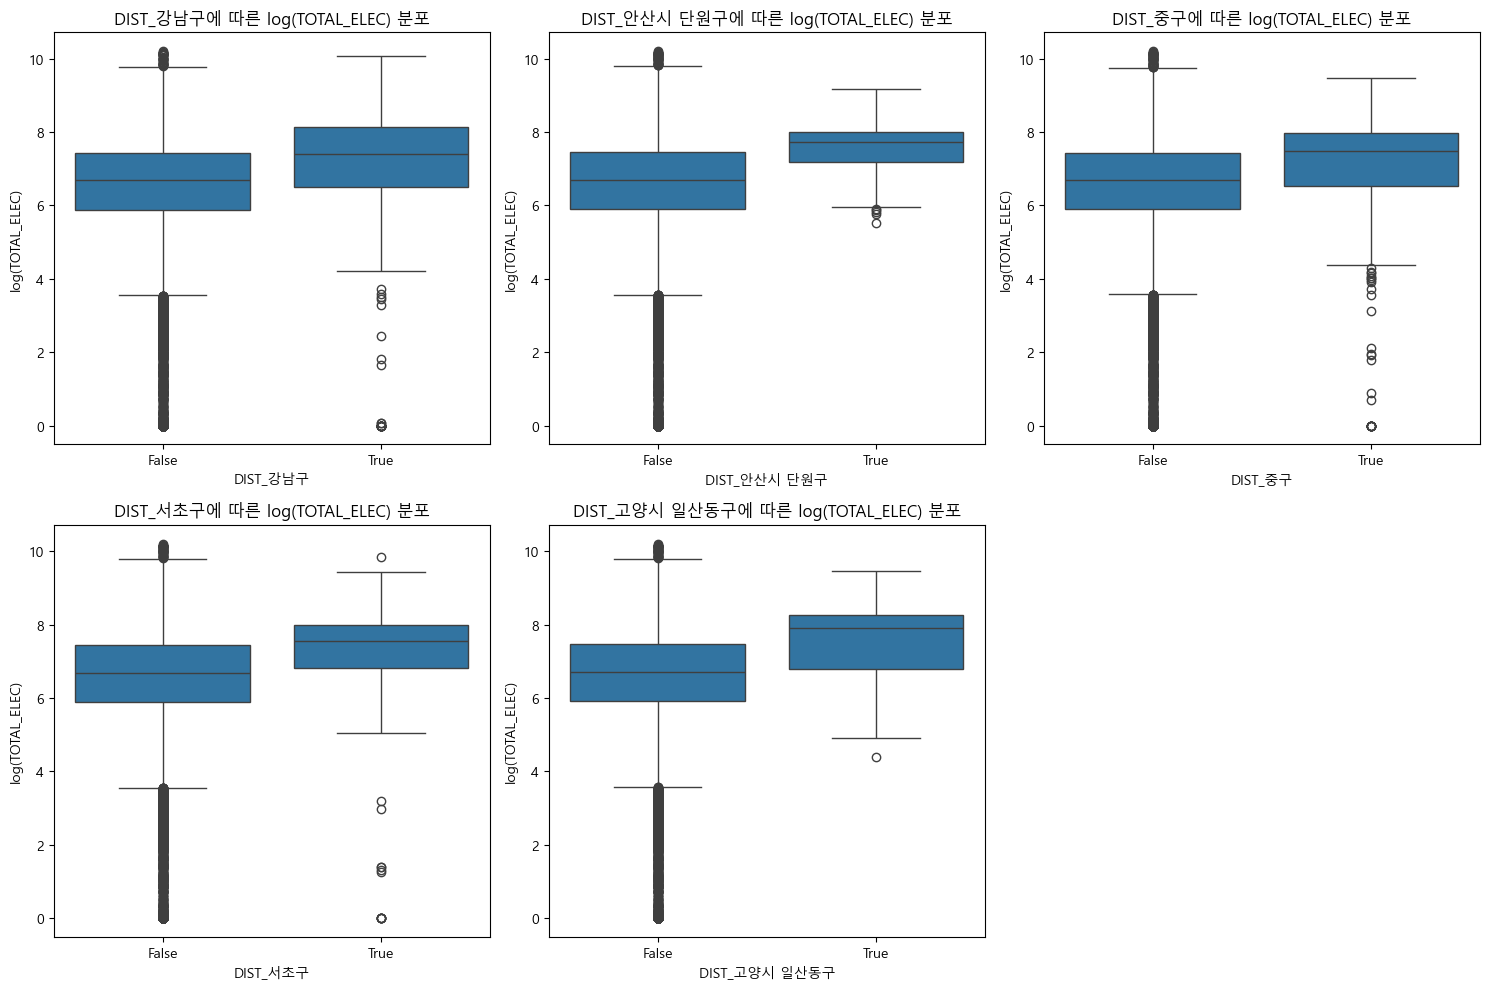

In [26]:
# DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정
print("\n=== DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정 ===")

# 원핫 인코딩 수행
dist_dummies = pd.get_dummies(train_df['DIST_NM'], prefix='DIST')
area_dummies = pd.get_dummies(train_df['AREA_NM'], prefix='AREA')

# 원핫 인코딩된 데이터프레임 생성
encoded_df = pd.concat([train_df, dist_dummies, area_dummies], axis=1)

# 원핫 인코딩된 변수 목록 확인
encoded_columns = list(dist_dummies.columns) + list(area_dummies.columns)
print(f"원핫 인코딩된 변수 수: {len(encoded_columns)}")

# 타겟값 로그 변환
log_total_elec = np.log1p(train_df['TOTAL_ELEC'])

# 통계적 검정 결과를 저장할 리스트
significant_vars = []
non_significant_vars = []
small_sample_vars = []  # 표본 크기가 30보다 작은 변수들

# 각 원핫 인코딩 변수에 대해 통계적 검정 수행
for col in encoded_columns:
    # 해당 변수가 1인 그룹과 0인 그룹으로 나누기
    group_1 = log_total_elec[encoded_df[col] == 1]
    group_0 = log_total_elec[encoded_df[col] == 0]
    
    # 그룹 크기가 20보다 작으면 건너뛰기 # 10보다 작은건 없음
    if len(group_1) < 20 or len(group_0) < 20:
        small_sample_vars.append({
            'variable': col,
            'group_1_size': len(group_1),
            'group_0_size': len(group_0)
        })
        continue
    
    # t-test 수행
    t_stat, p_value = stats.ttest_ind(group_1, group_0, equal_var=False)
    
    # 평균 차이 계산
    mean_diff = group_1.mean() - group_0.mean()
    
    # 유의성 판단 및 결과 저장
    alpha = 0.001
    result_dict = {
        'variable': col,
        'p_value': p_value,
        'mean_diff': mean_diff,
        't_stat': t_stat
    }
    
    if p_value < alpha:
        significant_vars.append(result_dict)
    else:
        non_significant_vars.append(result_dict)

# 결과 정렬 (p-value 기준)
significant_vars = sorted(significant_vars, key=lambda x: x['p_value'])
non_significant_vars = sorted(non_significant_vars, key=lambda x: x['p_value'])
small_sample_vars = sorted(small_sample_vars, key=lambda x: x['variable'])

# 표본 크기가 작은 변수 출력
print(f"\n=== 표본 크기가 20보다 작은 변수 ({len(small_sample_vars)}개) ===")
if small_sample_vars:
    small_sample_df = pd.DataFrame(small_sample_vars)
    print(small_sample_df.head(20))
    print(f"... 외 {max(0, len(small_sample_vars) - 20)}개")
else:
    print("표본 크기가 20보다 작은 변수가 없습니다.")

# 유의한 변수 출력
print(f"\n=== 통계적으로 유의한 변수 ({len(significant_vars)}개) ===")
if significant_vars:
    significant_df = pd.DataFrame(significant_vars)
    print(significant_df[['variable', 'p_value', 'mean_diff', 't_stat']].head(20))
    print(f"... 외 {max(0, len(significant_vars) - 20)}개")
else:
    print("통계적으로 유의한 변수가 없습니다.")

# 유의하지 않은 변수 출력
print(f"\n=== 통계적으로 유의하지 않은 변수 ({len(non_significant_vars)}개) ===")
if non_significant_vars:
    non_significant_df = pd.DataFrame(non_significant_vars)
    print(non_significant_df[['variable', 'p_value', 'mean_diff', 't_stat']].head(20))
    print(f"... 외 {max(0, len(non_significant_vars) - 20)}개")
else:
    print("통계적으로 유의하지 않은 변수가 없습니다.")

# 유의한 변수들의 분포 시각화 (상위 5개만)
if significant_vars:
    top_vars = [var['variable'] for var in significant_vars[:5]]
    
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(top_vars):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x=encoded_df[var], y=log_total_elec, data=train_df)
        plt.title(f'{var}에 따른 log(TOTAL_ELEC) 분포')
        plt.xlabel(var)
        plt.ylabel('log(TOTAL_ELEC)')
    
    plt.tight_layout()
    plt.show()



=== DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정 ===
원핫 인코딩된 변수 수: 1367

=== 표본 크기가 25보다 작은 변수 (986개) ===
                variable  group_1_size  group_0_size
0              AREA_LC타워            22         26077
1               AREA_MBC            23         26076
2               AREA_가능역            24         26075
3             AREA_가락시장역            23         26076
4   AREA_가리봉시장(구로디지털오거리)            22         26077
5        AREA_가산디지털단지역_3            24         26075
6           AREA_가야대학교 앞            22         26077
7               AREA_가오동            22         26077
8              AREA_가정1동            21         26078
9           AREA_가천의대길병원            22         26077
10              AREA_가평읍            21         26078
11              AREA_가호동            21         26078
12              AREA_각산역            23         26076
13           AREA_간석오거리역            22         26077
14              AREA_감삼역            24         26075
15            AREA_감전동_1            20         26079
16 

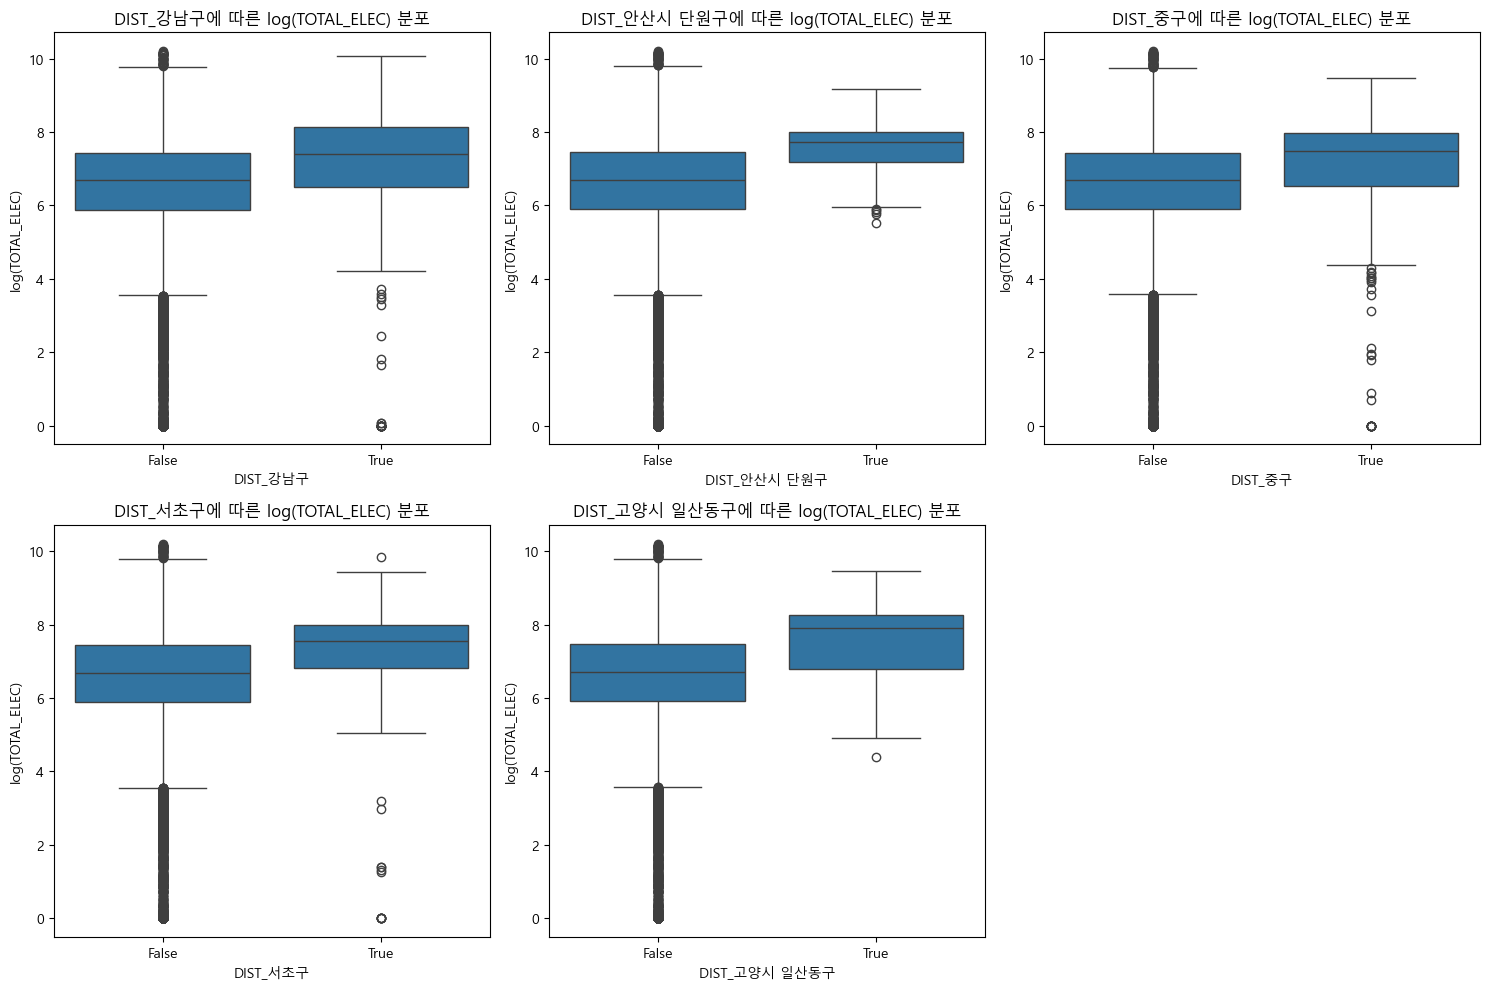

In [27]:
# DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정
print("\n=== DIST_NM과 AREA_NM의 원핫 인코딩 및 통계적 검정 ===")

# 원핫 인코딩 수행
dist_dummies = pd.get_dummies(train_df['DIST_NM'], prefix='DIST')
area_dummies = pd.get_dummies(train_df['AREA_NM'], prefix='AREA')

# 원핫 인코딩된 데이터프레임 생성
encoded_df = pd.concat([train_df, dist_dummies, area_dummies], axis=1)

# 원핫 인코딩된 변수 목록 확인
encoded_columns = list(dist_dummies.columns) + list(area_dummies.columns)
print(f"원핫 인코딩된 변수 수: {len(encoded_columns)}")

# 타겟값 로그 변환
log_total_elec = np.log1p(train_df['TOTAL_ELEC'])

# 통계적 검정 결과를 저장할 리스트
significant_vars = []
non_significant_vars = []
small_sample_vars = []  # 표본 크기가 30보다 작은 변수들

# 각 원핫 인코딩 변수에 대해 통계적 검정 수행
for col in encoded_columns:
    # 해당 변수가 1인 그룹과 0인 그룹으로 나누기
    group_1 = log_total_elec[encoded_df[col] == 1]
    group_0 = log_total_elec[encoded_df[col] == 0]
    
    # 그룹 크기가 25보다 작으면 건너뛰기 # 10보다 작은건 없음
    if len(group_1) < 25 or len(group_0) < 25:
        small_sample_vars.append({
            'variable': col,
            'group_1_size': len(group_1),
            'group_0_size': len(group_0)
        })
        continue
    
    # t-test 수행
    t_stat, p_value = stats.ttest_ind(group_1, group_0, equal_var=False)
    
    # 평균 차이 계산
    mean_diff = group_1.mean() - group_0.mean()
    
    # 유의성 판단 및 결과 저장
    alpha = 0.001
    result_dict = {
        'variable': col,
        'p_value': p_value,
        'mean_diff': mean_diff,
        't_stat': t_stat
    }
    
    if p_value < alpha:
        significant_vars.append(result_dict)
    else:
        non_significant_vars.append(result_dict)

# 결과 정렬 (p-value 기준)
significant_vars = sorted(significant_vars, key=lambda x: x['p_value'])
non_significant_vars = sorted(non_significant_vars, key=lambda x: x['p_value'])
small_sample_vars = sorted(small_sample_vars, key=lambda x: x['variable'])

# 표본 크기가 작은 변수 출력
print(f"\n=== 표본 크기가 25보다 작은 변수 ({len(small_sample_vars)}개) ===")
if small_sample_vars:
    small_sample_df = pd.DataFrame(small_sample_vars)
    print(small_sample_df.head(20))
    print(f"... 외 {max(0, len(small_sample_vars) - 20)}개")
else:
    print("표본 크기가 20보다 작은 변수가 없습니다.")

# 유의한 변수 출력
print(f"\n=== 통계적으로 유의한 변수 ({len(significant_vars)}개) ===")
if significant_vars:
    significant_df = pd.DataFrame(significant_vars)
    print(significant_df[['variable', 'p_value', 'mean_diff', 't_stat']].head(20))
    print(f"... 외 {max(0, len(significant_vars) - 20)}개")
else:
    print("통계적으로 유의한 변수가 없습니다.")

# 유의하지 않은 변수 출력
print(f"\n=== 통계적으로 유의하지 않은 변수 ({len(non_significant_vars)}개) ===")
if non_significant_vars:
    non_significant_df = pd.DataFrame(non_significant_vars)
    print(non_significant_df[['variable', 'p_value', 'mean_diff', 't_stat']].head(20))
    print(f"... 외 {max(0, len(non_significant_vars) - 20)}개")
else:
    print("통계적으로 유의하지 않은 변수가 없습니다.")

# 유의한 변수들의 분포 시각화 (상위 5개만)
if significant_vars:
    top_vars = [var['variable'] for var in significant_vars[:5]]
    
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(top_vars):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x=encoded_df[var], y=log_total_elec, data=train_df)
        plt.title(f'{var}에 따른 log(TOTAL_ELEC) 분포')
        plt.xlabel(var)
        plt.ylabel('log(TOTAL_ELEC)')
    
    plt.tight_layout()
    plt.show()


In [30]:
significant_df

,variable,p_value,mean_diff,t_stat
0,DIST_강남구,1.016842e-60,0.773936,17.312199
1,DIST_안산시 단원구,6.523898e-58,1.082805,21.714289
2,DIST_중구,3.700420e-49,0.688277,15.491617
3,DIST_서초구,5.411624e-46,0.905725,15.651047
4,DIST_고양시 일산동구,7.137148e-44,1.176566,17.510888
...,...,...,...,...
217,DIST_청양군,8.011638e-04,0.275908,3.813894
218,AREA_청양시외버스터미널,8.011638e-04,0.275908,3.813894
219,DIST_부천시,8.328549e-04,0.457839,3.412299
220,AREA_엠파크타워,8.409860e-04,-0.686074,-3.790201


In [31]:
significant_df[significant_df['variable'] == 'AREA_디지털미디어시티']

,variable,p_value,mean_diff,t_stat


In [33]:
significant_df[significant_df['variable'] == 'AREA_엑스코']

,variable,p_value,mean_diff,t_stat


In [32]:
significant_df[ significant_df['variable'].str.contains('AREA') ]

,variable,p_value,mean_diff,t_stat
6,AREA_광화문역_2,3.842689e-29,2.153776,50.996762
7,AREA_장산역_2,4.113727e-29,1.868487,48.688841
8,AREA_판교역,2.032886e-27,2.861034,51.681695
10,AREA_가평터미널,2.318114e-26,-2.066548,-42.366827
11,AREA_도리섬상점가상권,7.331702e-26,1.479363,36.135178
...,...,...,...,...
210,AREA_동부시장,4.556151e-04,-0.459664,-4.001562
213,AREA_순천시청,5.914988e-04,-0.253864,-3.927377
215,AREA_오산시청,6.747174e-04,0.624581,3.875476
218,AREA_청양시외버스터미널,8.011638e-04,0.275908,3.813894


In [35]:
a_list = significant_df['variable'].tolist()

# 2) 한 줄짜리 Python 리스트 문자열 생성 후 출력
one_line = '[' + ', '.join(f"'{x}'" for x in a_list) + ']'
one_line


"['DIST_강남구', 'DIST_안산시 단원구', 'DIST_중구', 'DIST_서초구', 'DIST_고양시 일산동구', 'DIST_부산진구', 'AREA_광화문역_2', 'AREA_장산역_2', 'AREA_판교역', 'DIST_안양시 동안구', 'AREA_가평터미널', 'AREA_도리섬상점가상권', 'DIST_거창군', 'AREA_교육청', 'AREA_석동', 'AREA_롯데백화점 본점', 'AREA_양림동', 'DIST_옥천군', 'AREA_옥천읍', 'AREA_역삼역_4', 'AREA_센텀시티역_2', 'DIST_창녕군', 'AREA_인천시청_2', 'AREA_천안역', 'AREA_구즉동', 'AREA_가산디지털단지역_1', 'AREA_충북혁신도시', 'AREA_명동', 'AREA_영통역_2', 'AREA_진천읍', 'AREA_온천장역', 'DIST_해운대구', 'AREA_신촌역_2', 'AREA_종로3가역_2', 'AREA_하당동_1', 'DIST_동대문구', 'DIST_영등포구', 'AREA_광천동', 'DIST_사하구', 'DIST_예산군', 'AREA_쌍촌동1', 'AREA_신흥역_1', 'DIST_성남시 분당구', 'AREA_하남', 'DIST_청도군', 'DIST_가평군', 'AREA_신림역_4', 'AREA_평택역_1', 'DIST_진도군', 'AREA_진도읍', 'DIST_전주시 완산구', 'AREA_논현역_3', 'DIST_마포구', 'AREA_교대역_4', 'AREA_국회의사당역_2', 'AREA_기장읍', 'AREA_마산시외터미널', 'AREA_역삼역_3', 'AREA_범어역', 'AREA_죽전카페거리', 'AREA_고속터미널역', 'AREA_상무지구3', 'AREA_영산면', 'AREA_안동시청_2', 'AREA_종로3가역_1', 'DIST_청주시 서원구', 'AREA_동대구역', 'AREA_연산9동_1', 'AREA_관양사거리', 'AREA_신당동', 'AREA_진영읍', 'DIST_금정구', 'AREA_진해역', 'AREA_정

1. 타겟인코딩
2. 타겟갑 상위 1~10위 하위 1~10위, other 도 고려


In [47]:
significant_df[significant_df['variable'] == 'AREA_NM_유천아파트앞']

,variable,p_value,mean_diff,t_stat


In [48]:
significant_df[significant_df['variable'] == 'AREA_NM_수원시청_1']

,variable,p_value,mean_diff,t_stat


In [25]:
# test_df와 train_df에서 범주형 변수 원핫인코딩 비교

# 원핫인코딩 함수 정의
def get_onehot_encoded_features(df, categorical_cols):
    encoded_df = pd.get_dummies(df[categorical_cols], drop_first=False)
    return encoded_df

# train_df와 test_df의 범주형 변수 원핫인코딩
categorical_cols = ['AREA_NM', 'DIST_NM']  # 원핫인코딩할 범주형 변수

train_encoded = get_onehot_encoded_features(train_df, categorical_cols)
test_encoded = get_onehot_encoded_features(test_df, categorical_cols)

# train과 test에 있는 모든 원핫인코딩 변수 확인
train_features = set(train_encoded.columns)
test_features = set(test_encoded.columns)

# 두 데이터셋 모두에 있는 변수
common_features = train_features.intersection(test_features)
print(f"\n=== train과 test 모두에 있는 원핫인코딩 변수 ({len(common_features)}개) ===")
print(sorted(list(common_features))[:20])
if len(common_features) > 20:
    print(f"... 외 {len(common_features) - 20}개")

# train에만 있는 변수
train_only_features = train_features - test_features
print(f"\n=== train에만 있는 원핫인코딩 변수 ({len(train_only_features)}개) ===")
print(sorted(list(train_only_features))[:20])
if len(train_only_features) > 20:
    print(f"... 외 {len(train_only_features) - 20}개")

# test에만 있는 변수
test_only_features = test_features - train_features
print(f"\n=== test에만 있는 원핫인코딩 변수 ({len(test_only_features)}개) ===")
print(sorted(list(test_only_features))[:20])
if len(test_only_features) > 20:
    print(f"... 외 {len(test_only_features) - 20}개")

# 원핫인코딩 변수 개수 비교
print(f"\n=== 원핫인코딩 변수 개수 비교 ===")
print(f"train 원핫인코딩 변수 개수: {len(train_features)}")
print(f"test 원핫인코딩 변수 개수: {len(test_features)}")
print(f"공통 변수 개수: {len(common_features)}")
print(f"train에만 있는 변수 개수: {len(train_only_features)}")
print(f"test에만 있는 변수 개수: {len(test_only_features)}")



=== train과 test 모두에 있는 원핫인코딩 변수 (1365개) ===
['AREA_NM_LC타워', 'AREA_NM_MBC', 'AREA_NM_가능역', 'AREA_NM_가능역2-3번출구', 'AREA_NM_가락시장', 'AREA_NM_가락시장역', 'AREA_NM_가리봉시장(구로디지털오거리)', 'AREA_NM_가산디지털단지역_1', 'AREA_NM_가산디지털단지역_2', 'AREA_NM_가산디지털단지역_3', 'AREA_NM_가야대학교 앞', 'AREA_NM_가오동', 'AREA_NM_가정1동', 'AREA_NM_가천의대길병원', 'AREA_NM_가평읍', 'AREA_NM_가평터미널', 'AREA_NM_가호동', 'AREA_NM_각산역', 'AREA_NM_간석오거리역', 'AREA_NM_간성시장 상권']
... 외 1345개

=== train에만 있는 원핫인코딩 변수 (2개) ===
['AREA_NM_수원시청_1', 'AREA_NM_유천아파트앞']

=== test에만 있는 원핫인코딩 변수 (0개) ===
[]

=== 원핫인코딩 변수 개수 비교 ===
train 원핫인코딩 변수 개수: 1367
test 원핫인코딩 변수 개수: 1365
공통 변수 개수: 1365
train에만 있는 변수 개수: 2
test에만 있는 변수 개수: 0


역 뿐만 아니라, 서울 + 역 변수도 유의미할 수 있음

=== 역 관련 지역 여부에 따른 데이터 분포 ===
IS_STATION
0    16897
1     9202
Name: count, dtype: int64

역 관련 지역 예시:
['신흥역_1' '태백역' '장지역' '대치역_2' '경기도청북부청사역_1' '구원주역' '행신역' '경성대부경대역_2'
 '신정네거리역' '영통역_1']

역 관련 아닌 지역 예시:
['평화2동_1' '팔공산 동화사' '종묘앞_1' '원주의료원' '화천공용버스터미널' '효자동_2' '청주법원' '남중동_1'
 '산격3동' '고성동']

=== 역 관련 지역 여부에 따른 TOTAL_ELEC 통계 ===
                   mean    median          std  count
IS_STATION                                           
0           1192.619925   674.714  1811.120429  16897
1           1951.264753  1194.122  2359.890478   9202


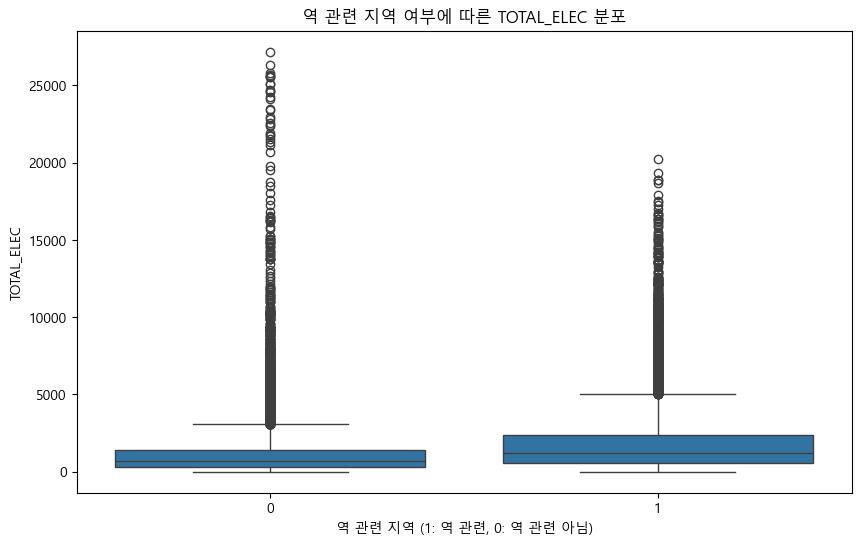

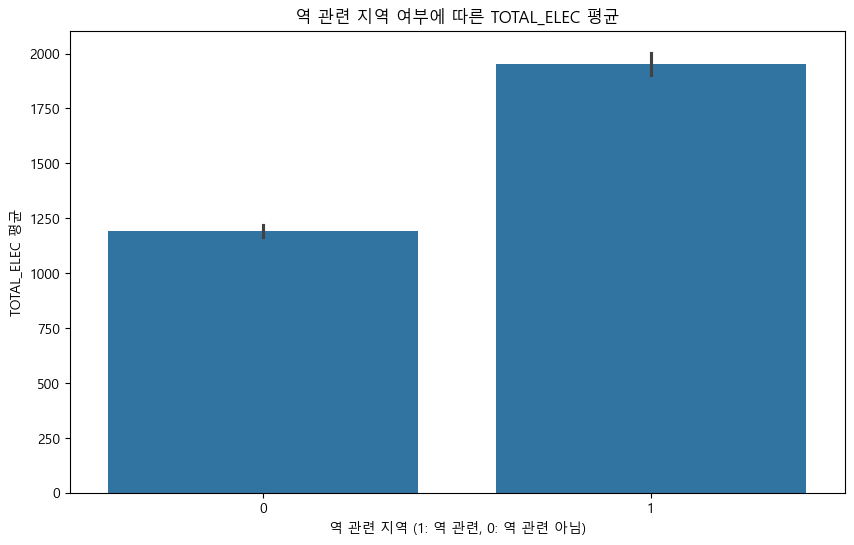

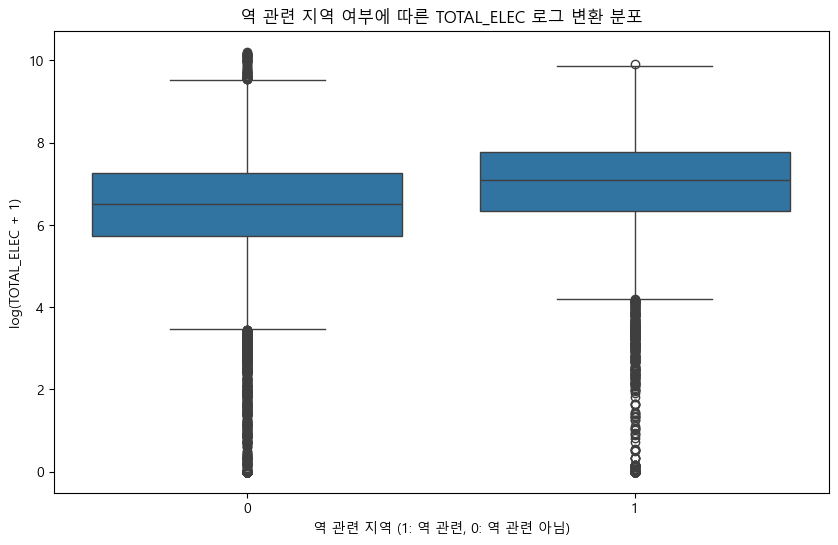

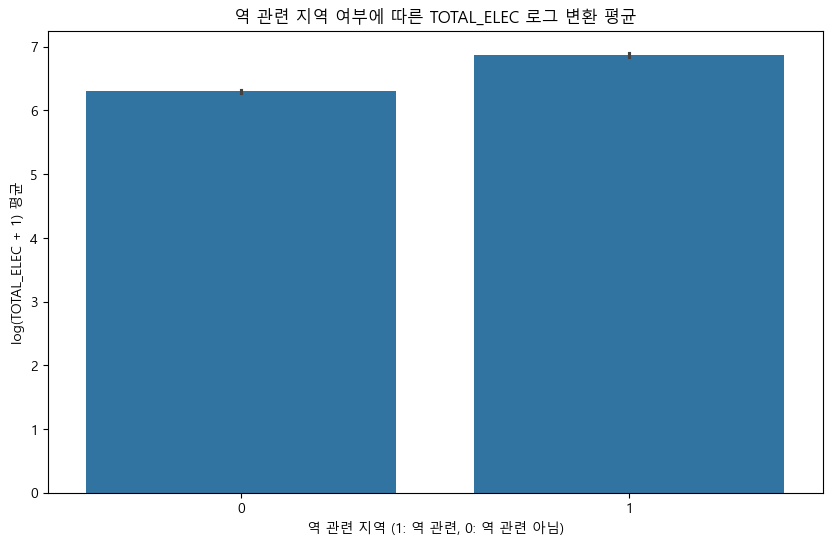


=== 역 관련 지역 여부에 따른 TOTAL_ELEC 로그 변환 평균 차이 검정 ===
t-통계량: 28.5764
p-값: 0.00000000
평균 차이 (역 관련 - 역 관련 아님): 0.5726
결론: 통계적으로 유의한 차이가 있습니다 (p < 0.05)


In [ ]:
# AREA_NM에서 '역' 또는 '역_숫자'로 끝나는 값 확인
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# '역' 또는 '역_숫자'로 끝나는 패턴 정의
station_pattern = re.compile(r'역(_\d+)?$')

# 새로운 변수 생성: 역 관련 지역인지 여부 (1: 역 관련, 0: 역 관련 아님)
train_df['IS_STATION'] = train_df['AREA_NM'].apply(lambda x: 1 if station_pattern.search(x) else 0)

# 결과 확인
print("=== 역 관련 지역 여부에 따른 데이터 분포 ===")
print(train_df['IS_STATION'].value_counts())
print("\n역 관련 지역 예시:")
station_examples = train_df[train_df['IS_STATION'] == 1]['AREA_NM'].unique()[:10]
print(station_examples)
print("\n역 관련 아닌 지역 예시:")
non_station_examples = train_df[train_df['IS_STATION'] == 0]['AREA_NM'].unique()[:10]
print(non_station_examples)

# 타겟 변수 (TOTAL_ELEC)와의 관계 분석
print("\n=== 역 관련 지역 여부에 따른 TOTAL_ELEC 통계 ===")
station_stats = train_df.groupby('IS_STATION')['TOTAL_ELEC'].agg(['mean', 'median', 'std', 'count'])
print(station_stats)

# 시각화 1: 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='IS_STATION', y='TOTAL_ELEC', data=train_df)
plt.title('역 관련 지역 여부에 따른 TOTAL_ELEC 분포')
plt.xlabel('역 관련 지역 (1: 역 관련, 0: 역 관련 아님)')
plt.ylabel('TOTAL_ELEC')
plt.show()

# 시각화 2: 바 플롯 (평균값)
plt.figure(figsize=(10, 6))
sns.barplot(x='IS_STATION', y='TOTAL_ELEC', data=train_df, estimator=np.mean)
plt.title('역 관련 지역 여부에 따른 TOTAL_ELEC 평균')
plt.xlabel('역 관련 지역 (1: 역 관련, 0: 역 관련 아님)')
plt.ylabel('TOTAL_ELEC 평균')
plt.show()

# 로그 변환 (FAC_TRAIN에 0이 있을 수 있으므로 log1p 사용)
train_df['TOTAL_ELEC_LOG'] = np.log1p(train_df['TOTAL_ELEC'])

# 시각화 3: 로그 변환 후 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='IS_STATION', y='TOTAL_ELEC_LOG', data=train_df)
plt.title('역 관련 지역 여부에 따른 TOTAL_ELEC 로그 변환 분포')
plt.xlabel('역 관련 지역 (1: 역 관련, 0: 역 관련 아님)')
plt.ylabel('log(TOTAL_ELEC + 1)')
plt.show()

# 시각화 4: 로그 변환 후 바 플롯 (평균값)
plt.figure(figsize=(10, 6))
sns.barplot(x='IS_STATION', y='TOTAL_ELEC_LOG', data=train_df, estimator=np.mean)
plt.title('역 관련 지역 여부에 따른 TOTAL_ELEC 로그 변환 평균')
plt.xlabel('역 관련 지역 (1: 역 관련, 0: 역 관련 아님)')
plt.ylabel('log(TOTAL_ELEC + 1) 평균')
plt.show()

# 통계 검정: 두 그룹 간 평균 차이 검정 (t-test)
station_group = train_df[train_df['IS_STATION'] == 1]['TOTAL_ELEC_LOG']
non_station_group = train_df[train_df['IS_STATION'] == 0]['TOTAL_ELEC_LOG']

t_stat, p_value = stats.ttest_ind(station_group, non_station_group, equal_var=False)
mean_diff = station_group.mean() - non_station_group.mean()

print("\n=== 역 관련 지역 여부에 따른 TOTAL_ELEC 로그 변환 평균 차이 검정 ===")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-값: {p_value:.8f}")
print(f"평균 차이 (역 관련 - 역 관련 아님): {mean_diff:.4f}")

if p_value < 0.05:
    print("결론: 통계적으로 유의한 차이가 있습니다 (p < 0.05)")
else:
    print("결론: 통계적으로 유의한 차이가 없습니다 (p >= 0.05)")


In [44]:
train_df[train_df['AREA_NM'].str.contains('읍') ]

,DATA_YM,AREA_ID,AREA_NM,DIST_CD,DIST_NM,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,...,FAC_LEISURE,TOTAL_GAS,CMRC_GAS,TOTAL_ELEC,IS_DMC,IS_COEX,IS_MAPO,IS_STATION,FAC_TRAIN_LOG,TOTAL_ELEC_LOG
19,202410,9685,구룡포읍,47111,포항시 남구,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.000,0,0,0,0,0.0,0.000000
41,202303,9396,양구읍,51800,양구군,590.0,117.0,132.0,1.0,3.0,...,6.0,0,0,0.000,0,0,0,0,0.0,0.000000
55,202410,9808,삼례읍_1,52710,완주군,4.0,1.0,1.0,0.0,0.0,...,0.0,0,0,0.000,0,0,0,0,0.0,0.000000
67,202303,9397,인제읍,51810,인제군,287.0,56.0,70.0,1.0,0.0,...,3.0,0,0,0.000,0,0,0,0,0.0,0.000000
110,202311,9809,삼례읍_2,52710,완주군,81.0,34.0,8.0,1.0,4.0,...,1.0,0,0,0.000,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23535,202301,9759,삼향읍,46840,무안군,83.0,36.0,25.0,0.0,0.0,...,0.0,2016634,601135,3278.045,0,0,0,0,0.0,8.095308
23536,202307,9759,삼향읍,46840,무안군,83.0,37.0,25.0,0.0,0.0,...,0.0,938431,495135,3278.886,0,0,0,0,0.0,8.095564
23551,202301,9759,삼향읍,46840,무안군,83.0,36.0,25.0,0.0,0.0,...,0.0,2320483,636667,3298.386,0,0,0,0,0.0,8.101492
23730,202407,9759,삼향읍,46840,무안군,84.0,35.0,27.0,0.0,0.0,...,0.0,993695,532429,3438.766,0,0,0,0,0.0,8.143159


=== 읍 관련 지역 여부에 따른 데이터 분포 ===
IS_eup
0    24840
1     1259
Name: count, dtype: int64

읍 관련 지역 예시:
['구룡포읍' '양구읍' '삼례읍_1' '인제읍' '삼례읍_2' '순창읍_3' '무주읍' '홍천읍' '연무읍' '영덕읍']

읍 관련 아닌 지역 예시:
['평화2동_1' '팔공산 동화사' '종묘앞_1' '원주의료원' '화천공용버스터미널' '효자동_2' '신흥역_1' '청주법원'
 '남중동_1' '산격3동']

=== 읍 관련 지역 여부에 따른 TOTAL_ELEC 통계 ===
               mean   median          std  count
IS_eup                                          
0       1505.918506  855.598  2091.369393  24840
1        556.172711  428.935   541.719261   1259


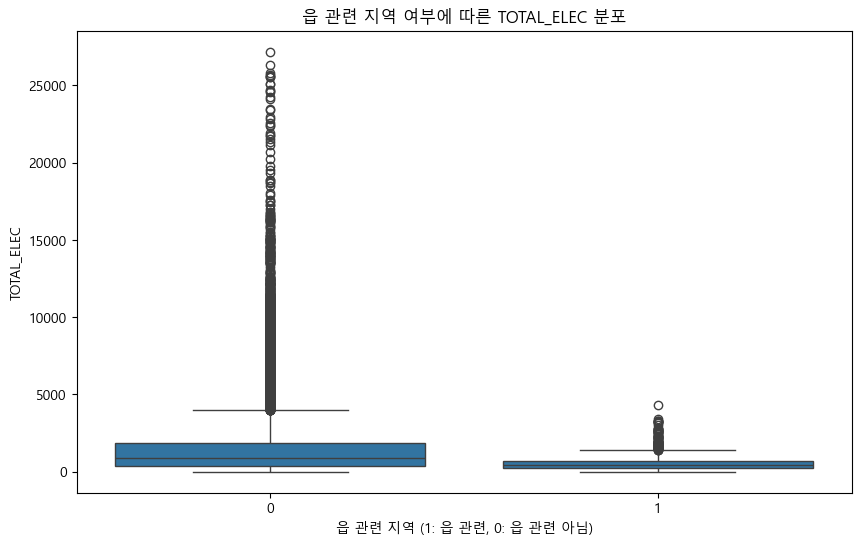

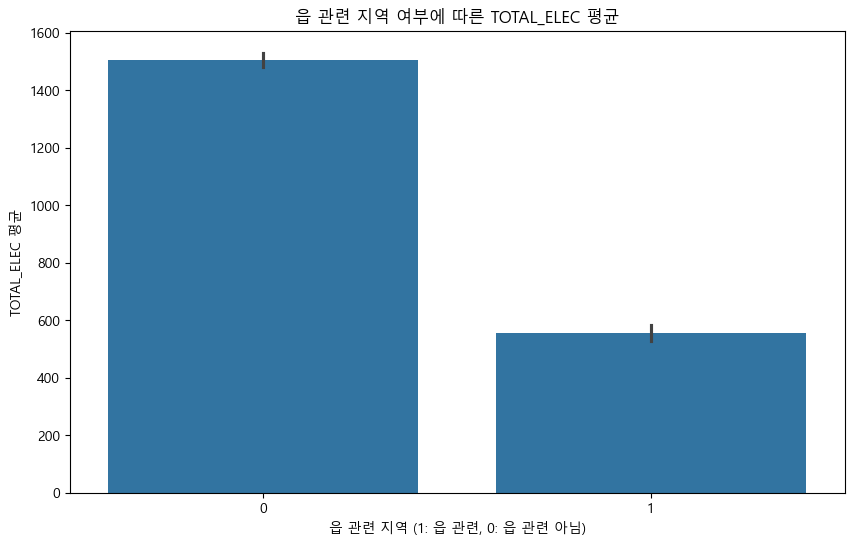

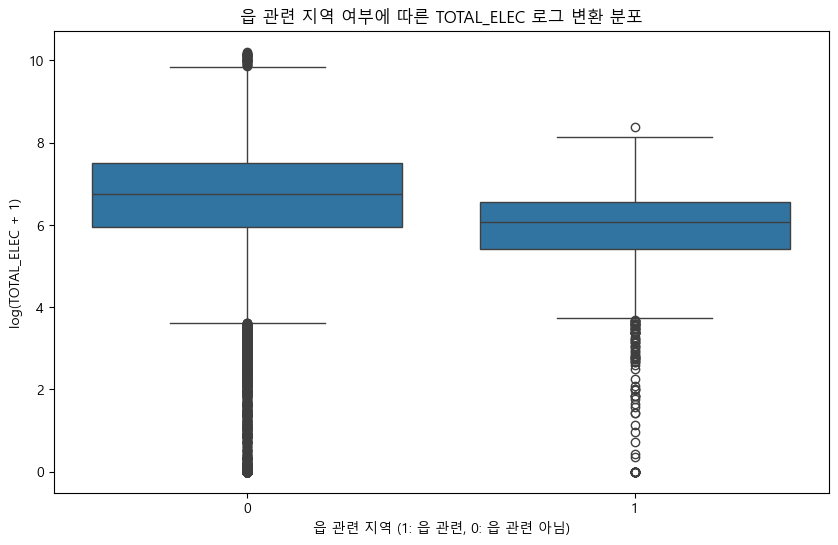

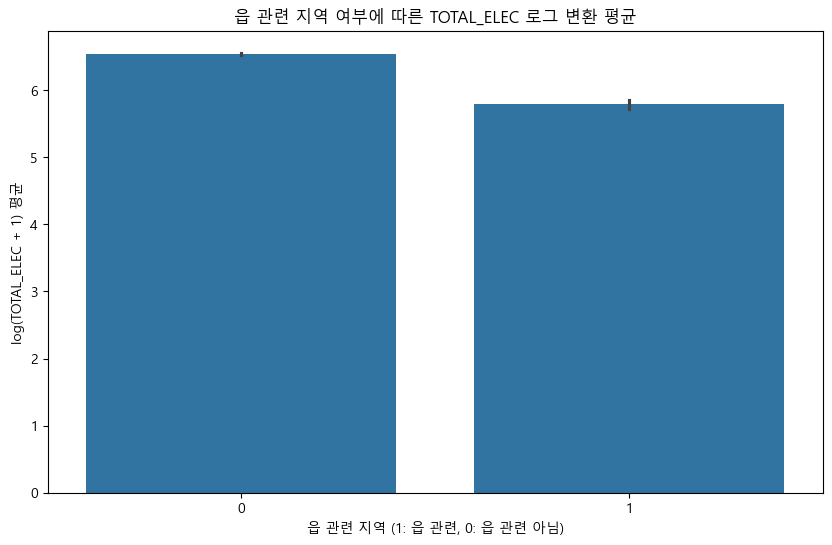


=== 읍 관련 지역 여부에 따른 TOTAL_ELEC 로그 변환 평균 차이 검정 ===
t-통계량: -19.2433
p-값: 0.00000000
평균 차이 (읍 관련 - 읍 관련 아님): -0.7504
결론: 통계적으로 유의한 차이가 있습니다 (p < 0.05)


In [ ]:
# AREA_NM에서 '읍' 또는 '읍_숫자'로 끝나는 값 확인
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# '읍' 또는 '읍_숫자'로 끝나는 패턴 정의
station_pattern = re.compile(r'읍(_\d+)?$')

# 새로운 변수 생성: 읍 관련 지역인지 여부 (1: 읍 관련, 0: 읍 관련 아님)
train_df['IS_eup'] = train_df['AREA_NM'].apply(lambda x: 1 if station_pattern.search(x) else 0)

# 결과 확인
print("=== 읍 관련 지역 여부에 따른 데이터 분포 ===")
print(train_df['IS_eup'].value_counts())
print("\n읍 관련 지역 예시:")
station_examples = train_df[train_df['IS_eup'] == 1]['AREA_NM'].unique()[:10]
print(station_examples)
print("\n읍 관련 아닌 지역 예시:")
non_station_examples = train_df[train_df['IS_eup'] == 0]['AREA_NM'].unique()[:10]
print(non_station_examples)

# 타겟 변수 (TOTAL_ELEC)와의 관계 분석
print("\n=== 읍 관련 지역 여부에 따른 TOTAL_ELEC 통계 ===")
station_stats = train_df.groupby('IS_eup')['TOTAL_ELEC'].agg(['mean', 'median', 'std', 'count'])
print(station_stats)

# 시각화 1: 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='IS_eup', y='TOTAL_ELEC', data=train_df)
plt.title('읍 관련 지역 여부에 따른 TOTAL_ELEC 분포')
plt.xlabel('읍 관련 지역 (1: 읍 관련, 0: 읍 관련 아님)')
plt.ylabel('TOTAL_ELEC')
plt.show()

# 시각화 2: 바 플롯 (평균값)
plt.figure(figsize=(10, 6))
sns.barplot(x='IS_eup', y='TOTAL_ELEC', data=train_df, estimator=np.mean)
plt.title('읍 관련 지역 여부에 따른 TOTAL_ELEC 평균')
plt.xlabel('읍 관련 지역 (1: 읍 관련, 0: 읍 관련 아님)')
plt.ylabel('TOTAL_ELEC 평균')
plt.show()

# 로그 변환 (FAC_TRAIN에 0이 있을 수 있으므로 log1p 사용)
train_df['TOTAL_ELEC_LOG'] = np.log1p(train_df['TOTAL_ELEC'])

# 시각화 3: 로그 변환 후 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='IS_eup', y='TOTAL_ELEC_LOG', data=train_df)
plt.title('읍 관련 지역 여부에 따른 TOTAL_ELEC 로그 변환 분포')
plt.xlabel('읍 관련 지역 (1: 읍 관련, 0: 읍 관련 아님)')
plt.ylabel('log(TOTAL_ELEC + 1)')
plt.show()

# 시각화 4: 로그 변환 후 바 플롯 (평균값)
plt.figure(figsize=(10, 6))
sns.barplot(x='IS_eup', y='TOTAL_ELEC_LOG', data=train_df, estimator=np.mean)
plt.title('읍 관련 지역 여부에 따른 TOTAL_ELEC 로그 변환 평균')
plt.xlabel('읍 관련 지역 (1: 읍 관련, 0: 읍 관련 아님)')
plt.ylabel('log(TOTAL_ELEC + 1) 평균')
plt.show()

# 통계 검정: 두 그룹 간 평균 차이 검정 (t-test)
station_group = train_df[train_df['IS_eup'] == 1]['TOTAL_ELEC_LOG']
non_station_group = train_df[train_df['IS_eup'] == 0]['TOTAL_ELEC_LOG']

t_stat, p_value = stats.ttest_ind(station_group, non_station_group, equal_var=False)
mean_diff = station_group.mean() - non_station_group.mean()

print("\n=== 읍 관련 지역 여부에 따른 TOTAL_ELEC 로그 변환 평균 차이 검정 ===")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-값: {p_value:.8f}")
print(f"평균 차이 (읍 관련 - 읍 관련 아님): {mean_diff:.4f}")

if p_value < 0.05:
    print("결론: 통계적으로 유의한 차이가 있습니다 (p < 0.05)")
else:
    print("결론: 통계적으로 유의한 차이가 없습니다 (p >= 0.05)")


In [46]:
1+1

2